In [1]:
import os
import math
import random
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
import pycocotools
from torch.utils.tensorboard import SummaryWriter

In [2]:
# if torch.cuda.is_available():  
#     device = "cuda:0" 
# else:  
#     device = "cpu" 
    
# torch.cuda.current_device()

In [3]:
# Code from Maastricht to access GPU of choice

import torch
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='0'


In [4]:
torch.cuda.set_device(0)
device = torch.device(f'cuda:{0}' if torch.cuda.is_available() else 'cpu')


In [5]:
torch.cuda.current_device(), torch.cuda.get_device_name()

(0, 'GeForce GTX 1080 Ti')

## Import data

In [6]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode


# Class for a customized dataset
# In this case preprocessed CEM images combined in a 3-channel RGB .jpg format
# and the corresponding mask of present lesions in a 1-channel .png format
class CustomImageDataset(Dataset):
    def __init__(self, root, annotations_file, img_dir, mask_dir, train=False, transform=None, target_transform=None):
        # Read the .csv file with all the information
        self.img_labels = pd.read_csv(os.path.join(root, annotations_file))
        # Define the directories of the images and masks
        self.img_dir = os.path.join(root, img_dir)
        self.mask_dir = os.path.join(root, mask_dir)
        # Define whethet transformations are included
        self.train = train
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        # Return the number of cases in the dataset
        # In this set, CC and MLO of the same breast are considered different cases
        return len(self.img_labels)

    def __getitem__(self, idx):
        # Read the image and the mask for a case from the directories
        img_path = self.img_labels.iloc[idx, 0]
        mask_path = self.img_labels.iloc[idx,6]
        img_path = img_path.replace('E:', '\\\\tsclient\E')
        mask_path = mask_path.replace('E:', '\\\\tsclient\E')
        image = read_image(img_path).float()
        mask = read_image(mask_path)
        
        xmin = self.img_labels.iloc[idx, 1]
        xmax = self.img_labels.iloc[idx, 2]
        ymin = self.img_labels.iloc[idx, 3]
        ymax = self.img_labels.iloc[idx, 4]
        
        # Apply transformations if defined
        flipint = random.random()
        if self.train and flipint > 0.5 :        
            image = T.RandomHorizontalFlip(p=1.0)(image)
            mask = T.RandomHorizontalFlip(p=1.0)(mask)
            
            ymax_temp = image.shape[0] - ymin
            ymin = image.shape[0] - ymax
            ymax = ymax_temp

        # Resize so all images and masks have the same size
#         image = T.Resize([800,800])(image)
#         mask = T.Resize([800,800])(mask)    
#         resize_scale_x = 800/image.size()[1]
#         resize_scale_y = 800/image.size()[2]

        # Resize if necessary
        # First the smallest dimension is reduced to 400 if it is larger
        # Then the largest dimension is reduced to 650 if it is still larger
        resize_scale = 1.0
        min_size_idx = np.argmin([image.size()[1], image.size()[2]])
        
        if min_size_idx == 0 and image.size()[1] > 400 :
            resize_scale *= 400/image.size()[1]
            image = T.Resize([400, int(400*image.size()[2]/image.size()[1])])(image)
            mask = T.Resize([400, int(400*image.size()[2]/image.size()[1])], interpolation=InterpolationMode.NEAREST)(mask)
        if min_size_idx == 0 and image.size()[2] > 650 :
            resize_scale *= 650/image.size()[2]
            image = T.Resize([int(650*image.size()[1]/image.size()[2]), 650])(image)
            mask = T.Resize([int(650*image.size()[1]/image.size()[2]), 650], interpolation=InterpolationMode.NEAREST)(mask)
        
        if min_size_idx == 1 and image.size()[2] > 400 :
            resize_scale *= 400/image.size()[2]
            image = T.Resize([int(400*image.size()[1]/image.size()[2]), 400])(image)
            mask = T.Resize([int(400*image.size()[1]/image.size()[2]), 400], interpolation=InterpolationMode.NEAREST)(mask)
        if min_size_idx == 1 and image.size()[1] > 650 :
            resize_scale *= 650/image.size()[1]
            image = T.Resize([650, int(650*image.size()[2]/image.size()[1])])(image)
            mask = T.Resize([650, int(650*image.size()[2]/image.size()[1])], interpolation=InterpolationMode.NEAREST)(mask)
            
        # Normalize image with mean and standard deviation per channel
        mean = torch.mean(image, dim=(1,2))
        stdev = torch.std(image, dim=(1,2))
        image = T.Normalize(mean, stdev)(image)
        
        # Rescale to [0,1] range per channel
        for dim in range(3) :
            image[dim] -= torch.min(image[dim])
            image[dim] /= torch.max(image[dim])  
        
        # Create separate channel in mask for each lesion
        mask_out = np.zeros((torch.max(mask).item(), mask.shape[-2], mask.shape[-1]))
        for lesion_idx in range(torch.max(mask).item()) :
#             mask_out[lesion_idx][mask[0]==lesion_idx+1] = 1  
            mask_out[lesion_idx][mask[0]>0] = 1 # alternative for wrong masks with only one lesion
        
        # Read the location of the lesion bounding box from the .csv file
        boxes = [[ymin*resize_scale, xmin*resize_scale, ymax*resize_scale, xmax*resize_scale]]
        # Read the label of the lesion from the .csv file
        labels = self.img_labels.iloc[idx, 5]  + 1   # 0 represents background class, thus 1=benign, 2=malignant
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        labels = torch.tensor([labels])
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        mask_out = torch.from_numpy(mask_out)
        mask_out = mask_out.to(torch.uint8)
        
        iscrowd = torch.zeros((2,), dtype=torch.int64)  
            
        target = {}
        target["image_id"] = image_id
        target["masks"] = mask_out
        target["boxes"] = boxes
        target["area"] = area
        target["labels"] = labels
        target["iscrowd"] = iscrowd
            
        return image, target


In [7]:
# import transforms as T

# def get_transform(train=False):
#     transforms = []
#     transforms.append(T.ToTensor())
    
#     if train:
#         transforms.append(T.RandomHorizontalFlip(0.5))
        
#     return T.Compose(transforms)

def get_transform(train=False) :
    if train :
        transforms = torch.nn.Sequential(T.RandomHorizontalFlip(p=0.5))
        
        return transforms
        
    else : 
        return None
    

In [8]:
traindatadir = 'B:\\Astrid\\Preprocessed\\train_set_preprocessedcalc'
trainval_data = CustomImageDataset(traindatadir, 'annotations_train_calccluster_real.csv', 'colored_to_jpg', 'mask_to_png', train=True)

testdatadir = 'B:\\Astrid\\Preprocessed\\test_set_preprocessedcalc'
test_data = CustomImageDataset(testdatadir, 'annotations_test_calccluster_real.csv', 'colored_to_jpg', 'mask_to_png')

savedir = 'B:\\Astrid\\Preprocessed\\ModelsAll'

In [9]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import utils
from torch.utils.data import random_split

# Read training dataset and split in training and validation data
train_data, val_data = random_split(trainval_data, [int(np.floor(len(trainval_data)*0.8)), int(np.ceil(len(trainval_data)*0.2))], generator=torch.Generator().manual_seed(42))
train_dataloader = DataLoader(train_data, batch_size=4, shuffle=True, collate_fn=utils.collate_fn)
val_dataloader = DataLoader(val_data, batch_size=4, shuffle=True, collate_fn=utils.collate_fn)

# Read test dataset
test_dataloader = DataLoader(test_data, batch_size=4, shuffle=True, collate_fn=utils.collate_fn)


In [10]:
len(train_data), len(val_data), len(test_data)

(255, 64, 108)

In [11]:
# For Training
train_images, train_targets = next(iter(train_dataloader))
train_image_list = list(image for image in train_images)
train_target_list = [{k: v for k, v in t.items()} for t in train_targets]

# For Validation
val_images, val_targets = next(iter(val_dataloader))
val_image_list = list(image for image in val_images)
val_target_list = [{k: v for k, v in t.items()} for t in val_targets]

# For Testing
test_images, test_targets = next(iter(test_dataloader))
test_image_list = list(image for image in test_images)
test_target_list = [{k: v for k, v in t.items()} for t in test_targets]

In [12]:
val_target_list

[{'image_id': tensor([198]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'boxes': tensor([[152.0399, 159.6682, 265.1491, 352.7430]]),
  'area': tensor([21838.5527]),
  'labels': tensor([2]),
  'iscrowd': tensor([0, 0])},
 {'image_id': tensor([53]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'boxes': te

In [13]:
test_target_list

[{'image_id': tensor([78]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'boxes': tensor([[ 38.0442, 108.5650, 126.4272, 133.8505]]),
  'area': tensor([2234.8052]),
  'labels': tensor([2]),
  'iscrowd': tensor([0, 0])},
 {'image_id': tensor([91]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 

In [14]:
train_targets[0]['image_id'], train_targets[1]['image_id'], train_targets[2]['image_id'], train_targets[3]['image_id']

(tensor([105]), tensor([217]), tensor([233]), tensor([202]))

tensor([105]) tensor([[114.2094, 203.6173, 204.5359, 283.5333]])
[153, 333, 64, 254]


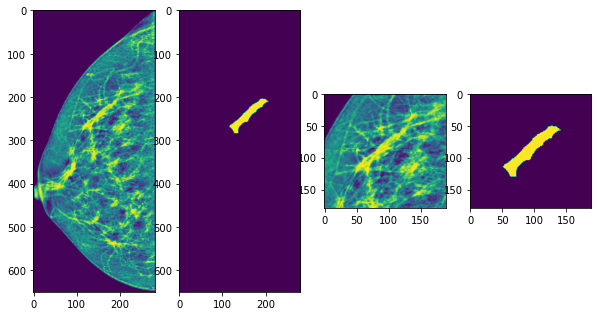

In [15]:
pat_idx = 0
print(train_targets[pat_idx]['image_id'], train_targets[pat_idx]['boxes'])

fig, ax = plt.subplots(1,4, figsize=(10,15))

ax[0].imshow(train_images[pat_idx][0])
ax[1].imshow(train_targets[pat_idx]['masks'][0])

enlarged_box = [int(train_targets[pat_idx]['boxes'][0][1])-50,
                int(train_targets[pat_idx]['boxes'][0][3])+50,
                int(train_targets[pat_idx]['boxes'][0][0])-50,                
                int(train_targets[pat_idx]['boxes'][0][2])+50]
print(enlarged_box)
ax[2].imshow(train_images[pat_idx][0, enlarged_box[0]:enlarged_box[1], enlarged_box[2]:enlarged_box[3]])
ax[3].imshow(train_targets[pat_idx]['masks'][0, enlarged_box[0]:enlarged_box[1], enlarged_box[2]:enlarged_box[3]])

tensor([198]) tensor([[152.0399, 159.6682, 265.1491, 352.7430]])
[109, 402, 102, 315]


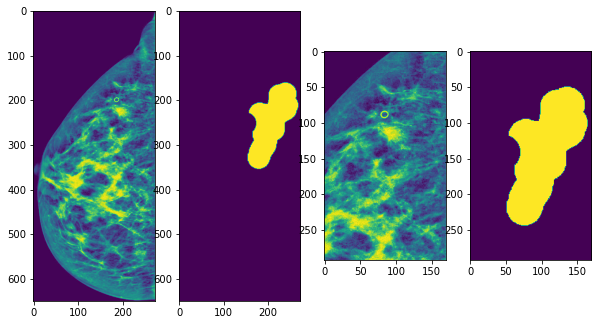

In [16]:
pat_idx = 0
print(val_targets[pat_idx]['image_id'], val_targets[pat_idx]['boxes'])

fig, ax = plt.subplots(1,4, figsize=(10,15))

ax[0].imshow(val_images[pat_idx][0])
ax[1].imshow(val_targets[pat_idx]['masks'][0])

enlarged_box = [int(val_targets[pat_idx]['boxes'][0][1])-50,
                int(val_targets[pat_idx]['boxes'][0][3])+50,
                int(val_targets[pat_idx]['boxes'][0][0])-50,                
                int(val_targets[pat_idx]['boxes'][0][2])+50]
print(enlarged_box)
ax[2].imshow(val_images[pat_idx][0, enlarged_box[0]:enlarged_box[1], enlarged_box[2]:enlarged_box[3]])
ax[3].imshow(val_targets[pat_idx]['masks'][0, enlarged_box[0]:enlarged_box[1], enlarged_box[2]:enlarged_box[3]])

## Define model

In [18]:
import torchvision
from torchvision.models.detection import FasterRCNN, MaskRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# backbone = torchvision.models.resnet50(pretrained=True, progress=True)
# backbone.out_channels = 1000

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

mask_roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                     output_size=14,
                                                     sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
# model = FasterRCNN(backbone,
#                    num_classes=3,
#                    rpn_anchor_generator=anchor_generator,
#                    box_roi_pool=roi_pooler)

# put the pieces together inside a MaskRCNN model
model = MaskRCNN(backbone,
                 num_classes=3,
                 rpn_anchor_generator=anchor_generator,
                 box_roi_pool=roi_pooler,
                 mask_roi_pool=mask_roi_pooler,
                 min_size=400,
                 max_size=650)

# import torchvision
# from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# num_classes = 2

# roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
#                                                 output_size=7,
#                                                 sampling_ratio=2)

# mask_roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
#                                                      output_size=14,
#                                                      sampling_ratio=2)

# anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
#                                    aspect_ratios=((0.5, 1.0, 2.0),))

# # load an instance segmentation model pre-trained on COCO
# model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True,
#                                                            box_roi_pool=roi_pooler,
#                                                            mask_roi_pool=mask_roi_pooler,
#                                                            min_size=400,
#                                                            max_size=650)

# # get number of input features for the classifier
# in_features = model.roi_heads.box_predictor.cls_score.in_features
# # replace the pre-trained head with a new one
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


# # now get the number of input features for the mask classifier
# in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
# hidden_layer = 256
# # and replace the mask predictor with a new one
# model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
#                                                    hidden_layer,
#                                                    num_classes)


In [19]:
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(400,), max_size=650, mode='bilinear')
  )
  (backbone): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
   

In [20]:
def train_one_epoch_kulum(model, optimizer, train_data_loader, val_data_loader, writer, device, epoch, print_freq, scaler=None):
    
    # Initialise training
    model.train()
    
    # Set up logger to save metrics and losses
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"Epoch: [{epoch}]"

    # Define scheduler for learning rate in optimizer
    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(train_data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    # Read the images and targets from the training data loader
    for images, targets in metric_logger.log_every(train_data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        # Compute the losses of the model on these training images and targets
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        # Reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])
           
        # Write to .tfevents
#         grid = torchvision.utils.make_grid(images)
#         writer.add_image('images', grid, 0)
#         writer.add_graph(model, images)
        
        writer.add_scalar('Loss/train', metric_logger.loss.value, epoch)
        writer.add_scalar('Loss classifier/train', metric_logger.loss_classifier.value, epoch)
        writer.add_scalar('Loss box reg/train', metric_logger.loss_box_reg.value, epoch)
        writer.add_scalar('Loss mask/train', metric_logger.loss_mask.value, epoch)
        writer.add_scalar('Loss objectness/train', metric_logger.loss_objectness.value, epoch)
        writer.add_scalar('Loss rpn box reg/train', metric_logger.loss_rpn_box_reg.value, epoch)
        
    # Set up logger to save metrics and losses of validation
    metric_logger_val = utils.MetricLogger(delimiter="  ")
    metric_logger_val.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
        
    # Read the images and targets from the validation data loader
    for images_val, targets_val in metric_logger_val.log_every(val_data_loader, print_freq, header):
        images_val = list(image.to(device) for image in images_val)
        targets_val = [{k: v.to(device) for k, v in t.items()} for t in targets_val]
        # Compute the losses of the model on these training images and targets
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict_val = model(images_val, targets_val)
            losses_val = sum(loss for loss in loss_dict_val.values())

        # Reduce losses over all GPUs for logging purposes
        loss_dict_reduced_val = utils.reduce_dict(loss_dict_val)
        losses_reduced_val = sum(loss for loss in loss_dict_reduced_val.values())

        loss_value_val = losses_reduced_val.item()
        
        metric_logger_val.update(loss=losses_reduced_val, **loss_dict_reduced_val)
        metric_logger_val.update(lr=optimizer.param_groups[0]["lr"])
        
        writer.add_scalar('Loss/val', metric_logger_val.loss.value, epoch)
        writer.add_scalar('Loss classifier/val', metric_logger_val.loss_classifier.value, epoch)
        writer.add_scalar('Loss box reg/val', metric_logger_val.loss_box_reg.value, epoch)
        writer.add_scalar('Loss mask/val', metric_logger_val.loss_mask.value, epoch)
        writer.add_scalar('Loss objectness/val', metric_logger_val.loss_objectness.value, epoch)
        writer.add_scalar('Loss rpn box reg/val', metric_logger_val.loss_rpn_box_reg.value, epoch)

    return metric_logger, metric_logger_val

def early_stopping_kulum(prev_loss, curr_loss, num_epochs) :
    
    if curr_loss > prev_loss :
        return num_epochs + 1
    else :
        return 0


In [21]:
from engine import train_one_epoch, evaluate

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

# model_writer = SummaryWriter('\\\\tsclient\\E\\runs\smallexpsynthetic')
model_writer = SummaryWriter('B:\\Astrid\\Preprocessed\\runs\\13_benmal')

# let's train it for 10 epochs
num_epochs = 200
logs = []
logs_val = []
min_val_loss = 0.0
stop_epoch = 0

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
#     sample_image, sample_target = sample(next(iter(train_dataloader)))
    
#     sample_image, sample_target = first(train_dataloader)
#     output = self.model(sample_image.to(self.device))
    
    epoch_loss, epoch_loss_val = train_one_epoch_kulum(model, optimizer, train_dataloader, val_dataloader, model_writer, device, epoch, print_freq=10)
#     epoch_loss = train_one_epoch(model, optimizer, train_dataloader, device, epoch, print_freq=10)
    logs.append(epoch_loss)
    logs_val.append(epoch_loss_val)
    
    # update the learning rate
#     lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, val_dataloader, device=device)
    
#     torch.save({
#                 'epoch': epoch,
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'loss': loss,
#                 'loss_classifier': loss_classifier,
#                 'loss_box_reg': loss_box_reg,
#                 'loss_mask': loss_mask,
#                 'loss_objectness': loss_objectness,
#                 'loss_rpn_box': loss_rpn_box
#                 }, savedir)

#     if epoch > 50 :
#         stop_epoch = early_stopping_kulum(min_val_loss, epoch_loss_val.loss.value, stop_epoch)
#         if stop_epoch > 5 :
#             print(f'Early stopping at epoch {epoch} with loss {epoch_loss_val.loss.value}.')

#             break

#         else :
#             min_val_loss = min(min_val_loss, epoch_loss_val.loss.value)
    
    if epoch % 10 == 0 :
        torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict()
                    }, os.path.join(savedir, 'model13_benmal_'+str(epoch)+'.pth'))
        
model_writer.close()

C:\Users\P70074720\.conda\envs\pytorch36\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [ 0/64]  eta: 0:10:12  lr: 0.000084  loss: 4.8992 (4.8992)  loss_classifier: 1.0596 (1.0596)  loss_box_reg: 0.0002 (0.0002)  loss_mask: 2.8420 (2.8420)  loss_objectness: 0.7209 (0.7209)  loss_rpn_box_reg: 0.2765 (0.2765)  time: 9.5678  data: 1.0379  max mem: 3048
Epoch: [0]  [10/64]  eta: 0:02:03  lr: 0.000877  loss: 3.2156 (3.4249)  loss_classifier: 0.6619 (0.6365)  loss_box_reg: 0.0004 (0.0041)  loss_mask: 1.6652 (1.8828)  loss_objectness: 0.7112 (0.6973)  loss_rpn_box_reg: 0.2765 (0.2042)  time: 2.2915  data: 1.1819  max mem: 3970
Epoch: [0]  [20/64]  eta: 0:01:27  lr: 0.001670  loss: 2.3979 (2.5713)  loss_classifier: 0.0586 (0.3525)  loss_box_reg: 0.0005 (0.0036)  loss_mask: 1.3277 (1.4671)  loss_objectness: 0.6018 (0.5802)  loss_rpn_box_reg: 0.0433 (0.1678)  time: 1.6054  data: 1.2297  max mem: 3970
Epoch: [0]  [30/64]  eta: 0:01:02  lr: 0.002463  loss: 1.3768 (2.1115)  loss_classifier: 0.0263 (0.2450)  loss_box_reg: 0.0005 (0.0028)  loss_mask: 0.8039 (1.2423)  loss_ob

Epoch: [1]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.4619 (0.4984)  loss_classifier: 0.0153 (0.0203)  loss_box_reg: 0.0026 (0.0059)  loss_mask: 0.3879 (0.3590)  loss_objectness: 0.0630 (0.0697)  loss_rpn_box_reg: 0.0333 (0.0436)  time: 1.1324  data: 0.9694  max mem: 5550
Epoch: [1] Total time: 0:00:18 (1.1330 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:25  model_time: 0.1250 (0.1250)  evaluator_time: 0.0040 (0.0040)  time: 1.5980  data: 1.4440  max mem: 5550
Test:  [15/16]  eta: 0:00:01  model_time: 0.1280 (0.1304)  evaluator_time: 0.0060 (0.0058)  time: 1.4587  data: 1.3152  max mem: 5550
Test: Total time: 0:00:23 (1.4589 s / it)
Averaged stats: model_time: 0.1280 (0.1304)  evaluator_time: 0.0060 (0.0058)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | 

Epoch: [3]  [ 0/64]  eta: 0:01:26  lr: 0.005000  loss: 0.5340 (0.5340)  loss_classifier: 0.0099 (0.0099)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.3829 (0.3829)  loss_objectness: 0.0937 (0.0937)  loss_rpn_box_reg: 0.0475 (0.0475)  time: 1.3480  data: 1.0080  max mem: 5550
Epoch: [3]  [10/64]  eta: 0:01:13  lr: 0.005000  loss: 0.5519 (0.4962)  loss_classifier: 0.0099 (0.0121)  loss_box_reg: 0.0000 (0.0016)  loss_mask: 0.4584 (0.3720)  loss_objectness: 0.0685 (0.0675)  loss_rpn_box_reg: 0.0475 (0.0429)  time: 1.3630  data: 1.0096  max mem: 5550
Epoch: [3]  [20/64]  eta: 0:01:00  lr: 0.005000  loss: 0.5519 (0.5084)  loss_classifier: 0.0099 (0.0129)  loss_box_reg: 0.0000 (0.0025)  loss_mask: 0.3839 (0.3649)  loss_objectness: 0.0609 (0.0742)  loss_rpn_box_reg: 0.0266 (0.0538)  time: 1.3753  data: 1.0161  max mem: 5550
Epoch: [3]  [30/64]  eta: 0:00:46  lr: 0.005000  loss: 0.5329 (0.5253)  loss_classifier: 0.0153 (0.0137)  loss_box_reg: 0.0021 (0.0028)  loss_mask: 0.3946 (0.3851)  loss_ob

Epoch: [4]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.6268 (0.6448)  loss_classifier: 0.0183 (0.0238)  loss_box_reg: 0.0037 (0.0074)  loss_mask: 0.5226 (0.5226)  loss_objectness: 0.0714 (0.0718)  loss_rpn_box_reg: 0.0083 (0.0193)  time: 1.0457  data: 0.8902  max mem: 5550
Epoch: [4] Total time: 0:00:16 (1.0463 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:24  model_time: 0.1450 (0.1450)  evaluator_time: 0.0060 (0.0060)  time: 1.5000  data: 1.3240  max mem: 5550
Test:  [15/16]  eta: 0:00:01  model_time: 0.1240 (0.1248)  evaluator_time: 0.0050 (0.0050)  time: 1.5262  data: 1.3880  max mem: 5550
Test: Total time: 0:00:24 (1.5265 s / it)
Averaged stats: model_time: 0.1240 (0.1248)  evaluator_time: 0.0050 (0.0050)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | 

Epoch: [6]  [ 0/64]  eta: 0:01:32  lr: 0.005000  loss: 0.5595 (0.5595)  loss_classifier: 0.0142 (0.0142)  loss_box_reg: 0.0042 (0.0042)  loss_mask: 0.3491 (0.3491)  loss_objectness: 0.0849 (0.0849)  loss_rpn_box_reg: 0.1071 (0.1071)  time: 1.4520  data: 1.1010  max mem: 5550
Epoch: [6]  [10/64]  eta: 0:01:17  lr: 0.005000  loss: 0.5445 (0.5126)  loss_classifier: 0.0125 (0.0148)  loss_box_reg: 0.0025 (0.0029)  loss_mask: 0.3531 (0.3904)  loss_objectness: 0.0506 (0.0521)  loss_rpn_box_reg: 0.0218 (0.0524)  time: 1.4297  data: 1.0692  max mem: 5550
Epoch: [6]  [20/64]  eta: 0:01:01  lr: 0.005000  loss: 0.4192 (0.4599)  loss_classifier: 0.0111 (0.0130)  loss_box_reg: 0.0000 (0.0025)  loss_mask: 0.3006 (0.3272)  loss_objectness: 0.0549 (0.0621)  loss_rpn_box_reg: 0.0218 (0.0552)  time: 1.3978  data: 1.0374  max mem: 5550
Epoch: [6]  [30/64]  eta: 0:00:47  lr: 0.005000  loss: 0.4500 (0.4771)  loss_classifier: 0.0102 (0.0141)  loss_box_reg: 0.0000 (0.0028)  loss_mask: 0.3450 (0.3541)  loss_ob

Epoch: [7]  [15/16]  eta: 0:00:00  lr: 0.005000  loss: 0.5553 (0.5366)  loss_classifier: 0.0135 (0.0201)  loss_box_reg: 0.0022 (0.0064)  loss_mask: 0.4789 (0.4397)  loss_objectness: 0.0404 (0.0488)  loss_rpn_box_reg: 0.0102 (0.0216)  time: 0.9723  data: 0.8220  max mem: 5611
Epoch: [7] Total time: 0:00:15 (0.9729 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:25  model_time: 0.1520 (0.1520)  evaluator_time: 0.0050 (0.0050)  time: 1.6180  data: 1.4350  max mem: 5611
Test:  [15/16]  eta: 0:00:01  model_time: 0.1350 (0.1351)  evaluator_time: 0.0050 (0.0051)  time: 1.5134  data: 1.3655  max mem: 5611
Test: Total time: 0:00:24 (1.5136 s / it)
Averaged stats: model_time: 0.1350 (0.1351)  evaluator_time: 0.0050 (0.0051)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | 

Epoch: [9]  [ 0/64]  eta: 0:01:34  lr: 0.005000  loss: 0.6988 (0.6988)  loss_classifier: 0.0142 (0.0142)  loss_box_reg: 0.0023 (0.0023)  loss_mask: 0.4457 (0.4457)  loss_objectness: 0.0913 (0.0913)  loss_rpn_box_reg: 0.1452 (0.1452)  time: 1.4780  data: 1.1090  max mem: 5611
Epoch: [9]  [10/64]  eta: 0:01:14  lr: 0.005000  loss: 0.3655 (0.3931)  loss_classifier: 0.0091 (0.0130)  loss_box_reg: 0.0000 (0.0029)  loss_mask: 0.2677 (0.2610)  loss_objectness: 0.0565 (0.0626)  loss_rpn_box_reg: 0.0185 (0.0536)  time: 1.3777  data: 1.0157  max mem: 5611
Epoch: [9]  [20/64]  eta: 0:01:02  lr: 0.005000  loss: 0.3655 (0.3984)  loss_classifier: 0.0105 (0.0132)  loss_box_reg: 0.0000 (0.0026)  loss_mask: 0.2773 (0.2845)  loss_objectness: 0.0478 (0.0585)  loss_rpn_box_reg: 0.0143 (0.0396)  time: 1.4068  data: 1.0428  max mem: 5611
Epoch: [9]  [30/64]  eta: 0:00:48  lr: 0.005000  loss: 0.4017 (0.4094)  loss_classifier: 0.0125 (0.0132)  loss_box_reg: 0.0017 (0.0024)  loss_mask: 0.3137 (0.3050)  loss_ob

Epoch: [10]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.4025 (0.4568)  loss_classifier: 0.0112 (0.0161)  loss_box_reg: 0.0018 (0.0044)  loss_mask: 0.3249 (0.3540)  loss_objectness: 0.0588 (0.0585)  loss_rpn_box_reg: 0.0123 (0.0237)  time: 1.0645  data: 0.9028  max mem: 5611
Epoch: [10] Total time: 0:00:17 (1.0653 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:22  model_time: 0.1520 (0.1520)  evaluator_time: 0.0070 (0.0070)  time: 1.3980  data: 1.2130  max mem: 5611
Test:  [15/16]  eta: 0:00:01  model_time: 0.1270 (0.1294)  evaluator_time: 0.0050 (0.0053)  time: 1.5847  data: 1.4425  max mem: 5611
Test: Total time: 0:00:25 (1.5849 s / it)
Averaged stats: model_time: 0.1270 (0.1294)  evaluator_time: 0.0050 (0.0053)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [12]  [ 0/64]  eta: 0:01:35  lr: 0.005000  loss: 0.2598 (0.2598)  loss_classifier: 0.0078 (0.0078)  loss_box_reg: 0.0022 (0.0022)  loss_mask: 0.2079 (0.2079)  loss_objectness: 0.0254 (0.0254)  loss_rpn_box_reg: 0.0165 (0.0165)  time: 1.4890  data: 1.1070  max mem: 5611
Epoch: [12]  [10/64]  eta: 0:01:11  lr: 0.005000  loss: 0.4840 (0.4732)  loss_classifier: 0.0146 (0.0173)  loss_box_reg: 0.0035 (0.0048)  loss_mask: 0.4054 (0.3878)  loss_objectness: 0.0339 (0.0405)  loss_rpn_box_reg: 0.0137 (0.0228)  time: 1.3177  data: 0.9628  max mem: 5611
Epoch: [12]  [20/64]  eta: 0:00:59  lr: 0.005000  loss: 0.4319 (0.4473)  loss_classifier: 0.0140 (0.0148)  loss_box_reg: 0.0023 (0.0035)  loss_mask: 0.3259 (0.3373)  loss_objectness: 0.0380 (0.0515)  loss_rpn_box_reg: 0.0131 (0.0401)  time: 1.3546  data: 0.9991  max mem: 5611
Epoch: [12]  [30/64]  eta: 0:00:46  lr: 0.005000  loss: 0.5224 (0.4886)  loss_classifier: 0.0154 (0.0165)  loss_box_reg: 0.0024 (0.0044)  loss_mask: 0.3614 (0.3731)  los

Epoch: [13]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.4928 (0.5246)  loss_classifier: 0.0130 (0.0170)  loss_box_reg: 0.0039 (0.0056)  loss_mask: 0.4292 (0.4195)  loss_objectness: 0.0422 (0.0503)  loss_rpn_box_reg: 0.0175 (0.0321)  time: 1.0853  data: 0.9329  max mem: 5611
Epoch: [13] Total time: 0:00:17 (1.0858 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:18  model_time: 0.1400 (0.1400)  evaluator_time: 0.0030 (0.0030)  time: 1.1860  data: 1.0210  max mem: 5611
Test:  [15/16]  eta: 0:00:01  model_time: 0.1320 (0.1313)  evaluator_time: 0.0060 (0.0055)  time: 1.4324  data: 1.2884  max mem: 5611
Test: Total time: 0:00:22 (1.4325 s / it)
Averaged stats: model_time: 0.1320 (0.1313)  evaluator_time: 0.0060 (0.0055)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [15]  [ 0/64]  eta: 0:01:21  lr: 0.005000  loss: 0.3689 (0.3689)  loss_classifier: 0.0101 (0.0101)  loss_box_reg: 0.0024 (0.0024)  loss_mask: 0.3155 (0.3155)  loss_objectness: 0.0334 (0.0334)  loss_rpn_box_reg: 0.0075 (0.0075)  time: 1.2710  data: 0.9020  max mem: 5611
Epoch: [15]  [10/64]  eta: 0:01:14  lr: 0.005000  loss: 0.4780 (0.4596)  loss_classifier: 0.0111 (0.0137)  loss_box_reg: 0.0019 (0.0030)  loss_mask: 0.3932 (0.3780)  loss_objectness: 0.0445 (0.0430)  loss_rpn_box_reg: 0.0114 (0.0218)  time: 1.3803  data: 1.0200  max mem: 5611
Epoch: [15]  [20/64]  eta: 0:01:00  lr: 0.005000  loss: 0.4686 (0.4510)  loss_classifier: 0.0103 (0.0141)  loss_box_reg: 0.0000 (0.0032)  loss_mask: 0.3260 (0.3644)  loss_objectness: 0.0445 (0.0461)  loss_rpn_box_reg: 0.0114 (0.0232)  time: 1.3885  data: 1.0312  max mem: 5611
Epoch: [15]  [30/64]  eta: 0:00:46  lr: 0.005000  loss: 0.3754 (0.4495)  loss_classifier: 0.0105 (0.0148)  loss_box_reg: 0.0011 (0.0037)  loss_mask: 0.2986 (0.3471)  los

Epoch: [16]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.4374 (0.4400)  loss_classifier: 0.0134 (0.0166)  loss_box_reg: 0.0018 (0.0046)  loss_mask: 0.3227 (0.3489)  loss_objectness: 0.0379 (0.0461)  loss_rpn_box_reg: 0.0197 (0.0238)  time: 1.0550  data: 0.9021  max mem: 5611
Epoch: [16] Total time: 0:00:16 (1.0557 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:20  model_time: 0.1370 (0.1370)  evaluator_time: 0.0030 (0.0030)  time: 1.2640  data: 1.1030  max mem: 5611
Test:  [15/16]  eta: 0:00:01  model_time: 0.1250 (0.1269)  evaluator_time: 0.0040 (0.0048)  time: 1.3560  data: 1.2177  max mem: 5611
Test: Total time: 0:00:21 (1.3562 s / it)
Averaged stats: model_time: 0.1250 (0.1269)  evaluator_time: 0.0040 (0.0048)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [18]  [ 0/64]  eta: 0:01:33  lr: 0.005000  loss: 0.4942 (0.4942)  loss_classifier: 0.0154 (0.0154)  loss_box_reg: 0.0038 (0.0038)  loss_mask: 0.4129 (0.4129)  loss_objectness: 0.0426 (0.0426)  loss_rpn_box_reg: 0.0195 (0.0195)  time: 1.4660  data: 1.0370  max mem: 5611
Epoch: [18]  [10/64]  eta: 0:01:16  lr: 0.005000  loss: 0.4942 (0.4414)  loss_classifier: 0.0151 (0.0171)  loss_box_reg: 0.0039 (0.0060)  loss_mask: 0.2990 (0.3164)  loss_objectness: 0.0518 (0.0530)  loss_rpn_box_reg: 0.0207 (0.0489)  time: 1.4230  data: 1.0488  max mem: 5611
Epoch: [18]  [20/64]  eta: 0:01:02  lr: 0.005000  loss: 0.4887 (0.4685)  loss_classifier: 0.0133 (0.0161)  loss_box_reg: 0.0021 (0.0052)  loss_mask: 0.3584 (0.3476)  loss_objectness: 0.0490 (0.0530)  loss_rpn_box_reg: 0.0170 (0.0465)  time: 1.4093  data: 1.0430  max mem: 5611
Epoch: [18]  [30/64]  eta: 0:00:47  lr: 0.005000  loss: 0.4303 (0.4352)  loss_classifier: 0.0115 (0.0147)  loss_box_reg: 0.0012 (0.0040)  loss_mask: 0.3596 (0.3294)  los

Epoch: [19]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.4517 (0.4413)  loss_classifier: 0.0097 (0.0135)  loss_box_reg: 0.0020 (0.0035)  loss_mask: 0.3433 (0.3378)  loss_objectness: 0.0458 (0.0521)  loss_rpn_box_reg: 0.0195 (0.0344)  time: 1.1203  data: 0.9591  max mem: 5611
Epoch: [19] Total time: 0:00:17 (1.1210 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:27  model_time: 0.1320 (0.1320)  evaluator_time: 0.0040 (0.0040)  time: 1.7480  data: 1.5890  max mem: 5611
Test:  [15/16]  eta: 0:00:01  model_time: 0.1260 (0.1279)  evaluator_time: 0.0050 (0.0052)  time: 1.5514  data: 1.4104  max mem: 5611
Test: Total time: 0:00:24 (1.5517 s / it)
Averaged stats: model_time: 0.1260 (0.1279)  evaluator_time: 0.0050 (0.0052)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [21]  [ 0/64]  eta: 0:01:25  lr: 0.005000  loss: 0.5345 (0.5345)  loss_classifier: 0.0125 (0.0125)  loss_box_reg: 0.0032 (0.0032)  loss_mask: 0.3945 (0.3945)  loss_objectness: 0.0770 (0.0770)  loss_rpn_box_reg: 0.0472 (0.0472)  time: 1.3310  data: 0.9220  max mem: 5611
Epoch: [21]  [10/64]  eta: 0:01:20  lr: 0.005000  loss: 0.4772 (0.4160)  loss_classifier: 0.0116 (0.0165)  loss_box_reg: 0.0000 (0.0051)  loss_mask: 0.3359 (0.3204)  loss_objectness: 0.0441 (0.0479)  loss_rpn_box_reg: 0.0263 (0.0262)  time: 1.4942  data: 1.1211  max mem: 5611
Epoch: [21]  [20/64]  eta: 0:01:03  lr: 0.005000  loss: 0.3969 (0.3834)  loss_classifier: 0.0116 (0.0138)  loss_box_reg: 0.0000 (0.0036)  loss_mask: 0.3304 (0.2874)  loss_objectness: 0.0404 (0.0505)  loss_rpn_box_reg: 0.0148 (0.0280)  time: 1.4534  data: 1.0835  max mem: 5611
Epoch: [21]  [30/64]  eta: 0:00:48  lr: 0.005000  loss: 0.4463 (0.4112)  loss_classifier: 0.0139 (0.0161)  loss_box_reg: 0.0040 (0.0051)  loss_mask: 0.3509 (0.3133)  los

Epoch: [22]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.4400 (0.4806)  loss_classifier: 0.0145 (0.0192)  loss_box_reg: 0.0026 (0.0058)  loss_mask: 0.3467 (0.3897)  loss_objectness: 0.0411 (0.0434)  loss_rpn_box_reg: 0.0157 (0.0224)  time: 1.1362  data: 0.9694  max mem: 5611
Epoch: [22] Total time: 0:00:18 (1.1368 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:27  model_time: 0.1360 (0.1360)  evaluator_time: 0.0070 (0.0070)  time: 1.6980  data: 1.5310  max mem: 5611
Test:  [15/16]  eta: 0:00:01  model_time: 0.1330 (0.1318)  evaluator_time: 0.0050 (0.0051)  time: 1.4194  data: 1.2760  max mem: 5611
Test: Total time: 0:00:22 (1.4196 s / it)
Averaged stats: model_time: 0.1330 (0.1318)  evaluator_time: 0.0050 (0.0051)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [24]  [ 0/64]  eta: 0:01:31  lr: 0.005000  loss: 0.4786 (0.4786)  loss_classifier: 0.0136 (0.0136)  loss_box_reg: 0.0056 (0.0056)  loss_mask: 0.4243 (0.4243)  loss_objectness: 0.0259 (0.0259)  loss_rpn_box_reg: 0.0092 (0.0092)  time: 1.4320  data: 1.0680  max mem: 5611
Epoch: [24]  [10/64]  eta: 0:01:10  lr: 0.005000  loss: 0.4005 (0.3921)  loss_classifier: 0.0084 (0.0099)  loss_box_reg: 0.0000 (0.0010)  loss_mask: 0.3117 (0.3243)  loss_objectness: 0.0365 (0.0385)  loss_rpn_box_reg: 0.0160 (0.0184)  time: 1.3070  data: 0.9506  max mem: 5611
Epoch: [24]  [20/64]  eta: 0:00:58  lr: 0.005000  loss: 0.3696 (0.3982)  loss_classifier: 0.0084 (0.0114)  loss_box_reg: 0.0000 (0.0020)  loss_mask: 0.2789 (0.3123)  loss_objectness: 0.0379 (0.0448)  loss_rpn_box_reg: 0.0179 (0.0277)  time: 1.3279  data: 0.9741  max mem: 5611
Epoch: [24]  [30/64]  eta: 0:00:46  lr: 0.005000  loss: 0.3307 (0.3869)  loss_classifier: 0.0087 (0.0112)  loss_box_reg: 0.0000 (0.0018)  loss_mask: 0.2786 (0.2999)  los

Epoch: [25]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.4178 (0.4603)  loss_classifier: 0.0112 (0.0174)  loss_box_reg: 0.0018 (0.0060)  loss_mask: 0.2983 (0.3595)  loss_objectness: 0.0434 (0.0509)  loss_rpn_box_reg: 0.0172 (0.0264)  time: 1.0945  data: 0.9307  max mem: 5611
Epoch: [25] Total time: 0:00:17 (1.0954 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:24  model_time: 0.1740 (0.1740)  evaluator_time: 0.0110 (0.0110)  time: 1.5390  data: 1.3310  max mem: 5611
Test:  [15/16]  eta: 0:00:01  model_time: 0.1370 (0.1397)  evaluator_time: 0.0070 (0.0074)  time: 1.6171  data: 1.4628  max mem: 5611
Test: Total time: 0:00:25 (1.6174 s / it)
Averaged stats: model_time: 0.1370 (0.1397)  evaluator_time: 0.0070 (0.0074)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [27]  [ 0/64]  eta: 0:01:19  lr: 0.005000  loss: 0.1349 (0.1349)  loss_classifier: 0.0039 (0.0039)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.0013 (0.0013)  loss_objectness: 0.0748 (0.0748)  loss_rpn_box_reg: 0.0549 (0.0549)  time: 1.2410  data: 0.8940  max mem: 5611
Epoch: [27]  [10/64]  eta: 0:01:14  lr: 0.005000  loss: 0.5075 (0.4563)  loss_classifier: 0.0220 (0.0207)  loss_box_reg: 0.0082 (0.0084)  loss_mask: 0.3957 (0.3592)  loss_objectness: 0.0375 (0.0457)  loss_rpn_box_reg: 0.0146 (0.0222)  time: 1.3713  data: 1.0018  max mem: 5611
Epoch: [27]  [20/64]  eta: 0:00:59  lr: 0.005000  loss: 0.4158 (0.4218)  loss_classifier: 0.0160 (0.0186)  loss_box_reg: 0.0051 (0.0071)  loss_mask: 0.3306 (0.3190)  loss_objectness: 0.0375 (0.0495)  loss_rpn_box_reg: 0.0126 (0.0275)  time: 1.3598  data: 0.9998  max mem: 5611
Epoch: [27]  [30/64]  eta: 0:00:46  lr: 0.005000  loss: 0.3893 (0.4151)  loss_classifier: 0.0121 (0.0171)  loss_box_reg: 0.0006 (0.0060)  loss_mask: 0.3154 (0.3166)  los

Epoch: [28]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.3999 (0.4387)  loss_classifier: 0.0097 (0.0164)  loss_box_reg: 0.0000 (0.0053)  loss_mask: 0.2961 (0.3395)  loss_objectness: 0.0407 (0.0445)  loss_rpn_box_reg: 0.0120 (0.0329)  time: 1.0828  data: 0.9266  max mem: 5611
Epoch: [28] Total time: 0:00:17 (1.0833 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:27  model_time: 0.1670 (0.1670)  evaluator_time: 0.0050 (0.0050)  time: 1.7290  data: 1.5341  max mem: 5611
Test:  [15/16]  eta: 0:00:01  model_time: 0.1410 (0.1398)  evaluator_time: 0.0060 (0.0067)  time: 1.4563  data: 1.3021  max mem: 5611
Test: Total time: 0:00:23 (1.4565 s / it)
Averaged stats: model_time: 0.1410 (0.1398)  evaluator_time: 0.0060 (0.0067)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [30]  [ 0/64]  eta: 0:01:39  lr: 0.005000  loss: 0.2633 (0.2633)  loss_classifier: 0.0086 (0.0086)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.1939 (0.1939)  loss_objectness: 0.0443 (0.0443)  loss_rpn_box_reg: 0.0166 (0.0166)  time: 1.5540  data: 1.1780  max mem: 5611
Epoch: [30]  [10/64]  eta: 0:01:15  lr: 0.005000  loss: 0.4320 (0.3864)  loss_classifier: 0.0133 (0.0135)  loss_box_reg: 0.0015 (0.0032)  loss_mask: 0.3592 (0.3026)  loss_objectness: 0.0426 (0.0422)  loss_rpn_box_reg: 0.0175 (0.0248)  time: 1.4042  data: 1.0375  max mem: 5611
Epoch: [30]  [20/64]  eta: 0:01:02  lr: 0.005000  loss: 0.4320 (0.3958)  loss_classifier: 0.0134 (0.0144)  loss_box_reg: 0.0021 (0.0036)  loss_mask: 0.3592 (0.3215)  loss_objectness: 0.0347 (0.0380)  loss_rpn_box_reg: 0.0099 (0.0183)  time: 1.4048  data: 1.0448  max mem: 5611
Epoch: [30]  [30/64]  eta: 0:00:47  lr: 0.005000  loss: 0.3234 (0.3807)  loss_classifier: 0.0094 (0.0134)  loss_box_reg: 0.0000 (0.0032)  loss_mask: 0.2245 (0.2908)  los

Epoch: [31]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.4108 (0.4297)  loss_classifier: 0.0116 (0.0178)  loss_box_reg: 0.0038 (0.0061)  loss_mask: 0.3066 (0.3351)  loss_objectness: 0.0342 (0.0455)  loss_rpn_box_reg: 0.0131 (0.0252)  time: 1.0838  data: 0.9265  max mem: 5611
Epoch: [31] Total time: 0:00:17 (1.0844 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:28  model_time: 0.1840 (0.1840)  evaluator_time: 0.0220 (0.0220)  time: 1.7530  data: 1.5230  max mem: 5611
Test:  [15/16]  eta: 0:00:01  model_time: 0.1490 (0.1544)  evaluator_time: 0.0110 (0.0129)  time: 1.5842  data: 1.4093  max mem: 5611
Test: Total time: 0:00:25 (1.5844 s / it)
Averaged stats: model_time: 0.1490 (0.1544)  evaluator_time: 0.0110 (0.0129)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [33]  [ 0/64]  eta: 0:01:33  lr: 0.005000  loss: 0.2150 (0.2150)  loss_classifier: 0.0070 (0.0070)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.1547 (0.1547)  loss_objectness: 0.0349 (0.0349)  loss_rpn_box_reg: 0.0184 (0.0184)  time: 1.4651  data: 1.0840  max mem: 5611
Epoch: [33]  [10/64]  eta: 0:01:16  lr: 0.005000  loss: 0.3908 (0.3478)  loss_classifier: 0.0107 (0.0109)  loss_box_reg: 0.0030 (0.0026)  loss_mask: 0.3135 (0.2670)  loss_objectness: 0.0373 (0.0399)  loss_rpn_box_reg: 0.0184 (0.0274)  time: 1.4203  data: 1.0536  max mem: 5611
Epoch: [33]  [20/64]  eta: 0:01:01  lr: 0.005000  loss: 0.4197 (0.3772)  loss_classifier: 0.0118 (0.0127)  loss_box_reg: 0.0029 (0.0034)  loss_mask: 0.3152 (0.2954)  loss_objectness: 0.0373 (0.0422)  loss_rpn_box_reg: 0.0115 (0.0235)  time: 1.3981  data: 1.0358  max mem: 5611
Epoch: [33]  [30/64]  eta: 0:00:48  lr: 0.005000  loss: 0.3578 (0.3600)  loss_classifier: 0.0101 (0.0120)  loss_box_reg: 0.0015 (0.0033)  loss_mask: 0.2613 (0.2730)  los

Epoch: [34]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.4849 (0.4568)  loss_classifier: 0.0120 (0.0170)  loss_box_reg: 0.0041 (0.0063)  loss_mask: 0.4118 (0.3425)  loss_objectness: 0.0386 (0.0508)  loss_rpn_box_reg: 0.0183 (0.0401)  time: 1.0886  data: 0.9294  max mem: 5611
Epoch: [34] Total time: 0:00:17 (1.0892 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:29  model_time: 0.1690 (0.1690)  evaluator_time: 0.0220 (0.0220)  time: 1.8550  data: 1.6430  max mem: 5611
Test:  [15/16]  eta: 0:00:01  model_time: 0.1650 (0.1677)  evaluator_time: 0.0160 (0.0198)  time: 1.6492  data: 1.4525  max mem: 5611
Test: Total time: 0:00:26 (1.6494 s / it)
Averaged stats: model_time: 0.1650 (0.1677)  evaluator_time: 0.0160 (0.0198)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [36]  [ 0/64]  eta: 0:01:03  lr: 0.005000  loss: 0.5048 (0.5048)  loss_classifier: 0.0147 (0.0147)  loss_box_reg: 0.0043 (0.0043)  loss_mask: 0.4555 (0.4555)  loss_objectness: 0.0242 (0.0242)  loss_rpn_box_reg: 0.0062 (0.0062)  time: 0.9950  data: 0.6510  max mem: 5611
Epoch: [36]  [10/64]  eta: 0:01:11  lr: 0.005000  loss: 0.4197 (0.4228)  loss_classifier: 0.0152 (0.0144)  loss_box_reg: 0.0052 (0.0055)  loss_mask: 0.3383 (0.3489)  loss_objectness: 0.0313 (0.0372)  loss_rpn_box_reg: 0.0111 (0.0168)  time: 1.3304  data: 0.9727  max mem: 5611
Epoch: [36]  [20/64]  eta: 0:00:59  lr: 0.005000  loss: 0.3943 (0.4069)  loss_classifier: 0.0130 (0.0131)  loss_box_reg: 0.0020 (0.0041)  loss_mask: 0.3150 (0.3131)  loss_objectness: 0.0384 (0.0477)  loss_rpn_box_reg: 0.0123 (0.0289)  time: 1.3777  data: 1.0219  max mem: 5611
Epoch: [36]  [30/64]  eta: 0:00:47  lr: 0.005000  loss: 0.2905 (0.3771)  loss_classifier: 0.0088 (0.0129)  loss_box_reg: 0.0000 (0.0038)  loss_mask: 0.2224 (0.2808)  los

Epoch: [37]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.5226 (0.5048)  loss_classifier: 0.0154 (0.0185)  loss_box_reg: 0.0026 (0.0064)  loss_mask: 0.3671 (0.3856)  loss_objectness: 0.0361 (0.0553)  loss_rpn_box_reg: 0.0122 (0.0390)  time: 1.0813  data: 0.9271  max mem: 5611
Epoch: [37] Total time: 0:00:17 (1.0819 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:23  model_time: 0.1730 (0.1730)  evaluator_time: 0.0190 (0.0190)  time: 1.4639  data: 1.2499  max mem: 5611
Test:  [15/16]  eta: 0:00:01  model_time: 0.1610 (0.1687)  evaluator_time: 0.0190 (0.0222)  time: 1.4930  data: 1.2935  max mem: 5611
Test: Total time: 0:00:23 (1.4933 s / it)
Averaged stats: model_time: 0.1610 (0.1687)  evaluator_time: 0.0190 (0.0222)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [39]  [ 0/64]  eta: 0:01:36  lr: 0.005000  loss: 0.4202 (0.4202)  loss_classifier: 0.0115 (0.0115)  loss_box_reg: 0.0039 (0.0039)  loss_mask: 0.3751 (0.3751)  loss_objectness: 0.0217 (0.0217)  loss_rpn_box_reg: 0.0080 (0.0080)  time: 1.5090  data: 1.1270  max mem: 5611
Epoch: [39]  [10/64]  eta: 0:01:14  lr: 0.005000  loss: 0.3948 (0.3371)  loss_classifier: 0.0101 (0.0114)  loss_box_reg: 0.0014 (0.0031)  loss_mask: 0.3300 (0.2553)  loss_objectness: 0.0397 (0.0403)  loss_rpn_box_reg: 0.0207 (0.0271)  time: 1.3730  data: 1.0183  max mem: 5611
Epoch: [39]  [20/64]  eta: 0:01:00  lr: 0.005000  loss: 0.3616 (0.3469)  loss_classifier: 0.0101 (0.0125)  loss_box_reg: 0.0013 (0.0036)  loss_mask: 0.2840 (0.2649)  loss_objectness: 0.0406 (0.0418)  loss_rpn_box_reg: 0.0207 (0.0241)  time: 1.3675  data: 1.0143  max mem: 5611
Epoch: [39]  [30/64]  eta: 0:00:46  lr: 0.005000  loss: 0.4231 (0.3621)  loss_classifier: 0.0107 (0.0129)  loss_box_reg: 0.0017 (0.0038)  loss_mask: 0.3487 (0.2779)  los

Epoch: [40]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.4398 (0.4479)  loss_classifier: 0.0134 (0.0165)  loss_box_reg: 0.0044 (0.0075)  loss_mask: 0.3495 (0.3377)  loss_objectness: 0.0375 (0.0518)  loss_rpn_box_reg: 0.0167 (0.0344)  time: 1.0793  data: 0.9259  max mem: 5611
Epoch: [40] Total time: 0:00:17 (1.0799 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:20  model_time: 0.1960 (0.1960)  evaluator_time: 0.0360 (0.0360)  time: 1.3069  data: 1.0490  max mem: 5611
Test:  [15/16]  eta: 0:00:01  model_time: 0.1710 (0.1870)  evaluator_time: 0.0260 (0.0300)  time: 1.5314  data: 1.3054  max mem: 5611
Test: Total time: 0:00:24 (1.5315 s / it)
Averaged stats: model_time: 0.1710 (0.1870)  evaluator_time: 0.0260 (0.0300)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [42]  [ 0/64]  eta: 0:01:31  lr: 0.005000  loss: 0.3603 (0.3603)  loss_classifier: 0.0109 (0.0109)  loss_box_reg: 0.0023 (0.0023)  loss_mask: 0.2675 (0.2675)  loss_objectness: 0.0557 (0.0557)  loss_rpn_box_reg: 0.0239 (0.0239)  time: 1.4220  data: 1.0660  max mem: 5611
Epoch: [42]  [10/64]  eta: 0:01:14  lr: 0.005000  loss: 0.3492 (0.3336)  loss_classifier: 0.0104 (0.0112)  loss_box_reg: 0.0014 (0.0031)  loss_mask: 0.2530 (0.2346)  loss_objectness: 0.0365 (0.0439)  loss_rpn_box_reg: 0.0330 (0.0408)  time: 1.3726  data: 1.0170  max mem: 5611
Epoch: [42]  [20/64]  eta: 0:00:59  lr: 0.005000  loss: 0.3273 (0.3301)  loss_classifier: 0.0104 (0.0111)  loss_box_reg: 0.0014 (0.0033)  loss_mask: 0.2530 (0.2429)  loss_objectness: 0.0361 (0.0407)  loss_rpn_box_reg: 0.0174 (0.0321)  time: 1.3606  data: 1.0041  max mem: 5611
Epoch: [42]  [30/64]  eta: 0:00:46  lr: 0.005000  loss: 0.3344 (0.3302)  loss_classifier: 0.0108 (0.0110)  loss_box_reg: 0.0005 (0.0027)  loss_mask: 0.2853 (0.2515)  los

Epoch: [43]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.4208 (0.4362)  loss_classifier: 0.0130 (0.0186)  loss_box_reg: 0.0031 (0.0067)  loss_mask: 0.3320 (0.3238)  loss_objectness: 0.0374 (0.0543)  loss_rpn_box_reg: 0.0151 (0.0327)  time: 1.0524  data: 0.8976  max mem: 5611
Epoch: [43] Total time: 0:00:16 (1.0529 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:33  model_time: 0.1530 (0.1530)  evaluator_time: 0.0070 (0.0070)  time: 2.0740  data: 1.8890  max mem: 5611
Test:  [15/16]  eta: 0:00:01  model_time: 0.1770 (0.1996)  evaluator_time: 0.0240 (0.0371)  time: 1.6363  data: 1.3899  max mem: 5611
Test: Total time: 0:00:26 (1.6366 s / it)
Averaged stats: model_time: 0.1770 (0.1996)  evaluator_time: 0.0240 (0.0371)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [45]  [ 0/64]  eta: 0:01:23  lr: 0.005000  loss: 0.2161 (0.2161)  loss_classifier: 0.0108 (0.0108)  loss_box_reg: 0.0028 (0.0028)  loss_mask: 0.1568 (0.1568)  loss_objectness: 0.0319 (0.0319)  loss_rpn_box_reg: 0.0139 (0.0139)  time: 1.3020  data: 0.9580  max mem: 5611
Epoch: [45]  [10/64]  eta: 0:01:14  lr: 0.005000  loss: 0.4122 (0.3787)  loss_classifier: 0.0126 (0.0163)  loss_box_reg: 0.0042 (0.0065)  loss_mask: 0.3024 (0.2954)  loss_objectness: 0.0319 (0.0375)  loss_rpn_box_reg: 0.0138 (0.0230)  time: 1.3716  data: 0.9971  max mem: 5611
Epoch: [45]  [20/64]  eta: 0:00:59  lr: 0.005000  loss: 0.3670 (0.3767)  loss_classifier: 0.0146 (0.0147)  loss_box_reg: 0.0042 (0.0050)  loss_mask: 0.2875 (0.2866)  loss_objectness: 0.0284 (0.0423)  loss_rpn_box_reg: 0.0121 (0.0282)  time: 1.3439  data: 0.9746  max mem: 5611
Epoch: [45]  [30/64]  eta: 0:00:46  lr: 0.005000  loss: 0.3357 (0.3634)  loss_classifier: 0.0128 (0.0136)  loss_box_reg: 0.0028 (0.0046)  loss_mask: 0.2671 (0.2701)  los

Epoch: [46]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.4330 (0.4524)  loss_classifier: 0.0113 (0.0143)  loss_box_reg: 0.0016 (0.0039)  loss_mask: 0.3613 (0.3608)  loss_objectness: 0.0340 (0.0467)  loss_rpn_box_reg: 0.0126 (0.0266)  time: 1.0962  data: 0.9323  max mem: 5611
Epoch: [46] Total time: 0:00:17 (1.0968 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:29  model_time: 0.1860 (0.1860)  evaluator_time: 0.0200 (0.0200)  time: 1.8559  data: 1.6269  max mem: 5611
Test:  [15/16]  eta: 0:00:01  model_time: 0.1880 (0.2187)  evaluator_time: 0.0310 (0.0448)  time: 1.6762  data: 1.4011  max mem: 5611
Test: Total time: 0:00:26 (1.6764 s / it)
Averaged stats: model_time: 0.1880 (0.2187)  evaluator_time: 0.0310 (0.0448)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [48]  [ 0/64]  eta: 0:01:32  lr: 0.005000  loss: 0.1024 (0.1024)  loss_classifier: 0.0054 (0.0054)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.0007 (0.0007)  loss_objectness: 0.0502 (0.0502)  loss_rpn_box_reg: 0.0460 (0.0460)  time: 1.4380  data: 1.0840  max mem: 5611
Epoch: [48]  [10/64]  eta: 0:01:19  lr: 0.005000  loss: 0.3376 (0.3386)  loss_classifier: 0.0098 (0.0141)  loss_box_reg: 0.0023 (0.0050)  loss_mask: 0.2517 (0.2561)  loss_objectness: 0.0333 (0.0352)  loss_rpn_box_reg: 0.0131 (0.0283)  time: 1.4736  data: 1.1059  max mem: 5611
Epoch: [48]  [20/64]  eta: 0:01:03  lr: 0.005000  loss: 0.3599 (0.3365)  loss_classifier: 0.0098 (0.0128)  loss_box_reg: 0.0023 (0.0048)  loss_mask: 0.2525 (0.2504)  loss_objectness: 0.0310 (0.0354)  loss_rpn_box_reg: 0.0137 (0.0332)  time: 1.4344  data: 1.0716  max mem: 5611
Epoch: [48]  [30/64]  eta: 0:00:48  lr: 0.005000  loss: 0.3582 (0.3214)  loss_classifier: 0.0083 (0.0125)  loss_box_reg: 0.0020 (0.0046)  loss_mask: 0.2805 (0.2357)  los

Epoch: [49]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.5256 (0.5814)  loss_classifier: 0.0108 (0.0148)  loss_box_reg: 0.0019 (0.0037)  loss_mask: 0.4618 (0.4718)  loss_objectness: 0.0365 (0.0608)  loss_rpn_box_reg: 0.0172 (0.0303)  time: 1.1804  data: 1.0147  max mem: 5611
Epoch: [49] Total time: 0:00:18 (1.1811 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:30  model_time: 0.1540 (0.1540)  evaluator_time: 0.0060 (0.0060)  time: 1.8790  data: 1.6900  max mem: 5611
Test:  [15/16]  eta: 0:00:01  model_time: 0.1530 (0.1621)  evaluator_time: 0.0120 (0.0192)  time: 1.5484  data: 1.3592  max mem: 5611
Test: Total time: 0:00:24 (1.5486 s / it)
Averaged stats: model_time: 0.1530 (0.1621)  evaluator_time: 0.0120 (0.0192)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [51]  [ 0/64]  eta: 0:01:42  lr: 0.005000  loss: 0.2534 (0.2534)  loss_classifier: 0.0041 (0.0041)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.1162 (0.1162)  loss_objectness: 0.0733 (0.0733)  loss_rpn_box_reg: 0.0598 (0.0598)  time: 1.5999  data: 1.1599  max mem: 5611
Epoch: [51]  [10/64]  eta: 0:01:16  lr: 0.005000  loss: 0.3767 (0.3687)  loss_classifier: 0.0142 (0.0133)  loss_box_reg: 0.0018 (0.0050)  loss_mask: 0.2611 (0.2700)  loss_objectness: 0.0315 (0.0358)  loss_rpn_box_reg: 0.0217 (0.0446)  time: 1.4180  data: 1.0431  max mem: 5611
Epoch: [51]  [20/64]  eta: 0:01:00  lr: 0.005000  loss: 0.3712 (0.3455)  loss_classifier: 0.0130 (0.0130)  loss_box_reg: 0.0032 (0.0051)  loss_mask: 0.2611 (0.2535)  loss_objectness: 0.0329 (0.0353)  loss_rpn_box_reg: 0.0121 (0.0386)  time: 1.3752  data: 1.0091  max mem: 5611
Epoch: [51]  [30/64]  eta: 0:00:47  lr: 0.005000  loss: 0.3427 (0.3327)  loss_classifier: 0.0092 (0.0132)  loss_box_reg: 0.0032 (0.0052)  loss_mask: 0.2116 (0.2397)  los

Epoch: [52]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.4012 (0.4329)  loss_classifier: 0.0106 (0.0153)  loss_box_reg: 0.0001 (0.0050)  loss_mask: 0.2908 (0.3224)  loss_objectness: 0.0411 (0.0580)  loss_rpn_box_reg: 0.0153 (0.0322)  time: 1.1702  data: 1.0109  max mem: 5611
Epoch: [52] Total time: 0:00:18 (1.1709 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:22  model_time: 0.1720 (0.1720)  evaluator_time: 0.0180 (0.0180)  time: 1.3880  data: 1.1750  max mem: 5611
Test:  [15/16]  eta: 0:00:01  model_time: 0.1610 (0.1710)  evaluator_time: 0.0170 (0.0258)  time: 1.6736  data: 1.4679  max mem: 5611
Test: Total time: 0:00:26 (1.6738 s / it)
Averaged stats: model_time: 0.1610 (0.1710)  evaluator_time: 0.0170 (0.0258)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [54]  [ 0/64]  eta: 0:01:19  lr: 0.005000  loss: 0.4892 (0.4892)  loss_classifier: 0.0117 (0.0117)  loss_box_reg: 0.0001 (0.0001)  loss_mask: 0.4343 (0.4343)  loss_objectness: 0.0319 (0.0319)  loss_rpn_box_reg: 0.0111 (0.0111)  time: 1.2480  data: 0.8960  max mem: 5611
Epoch: [54]  [10/64]  eta: 0:01:11  lr: 0.005000  loss: 0.3430 (0.3432)  loss_classifier: 0.0117 (0.0118)  loss_box_reg: 0.0019 (0.0045)  loss_mask: 0.2977 (0.2794)  loss_objectness: 0.0253 (0.0292)  loss_rpn_box_reg: 0.0075 (0.0184)  time: 1.3213  data: 0.9566  max mem: 5611
Epoch: [54]  [20/64]  eta: 0:00:58  lr: 0.005000  loss: 0.3135 (0.3287)  loss_classifier: 0.0101 (0.0125)  loss_box_reg: 0.0021 (0.0041)  loss_mask: 0.2517 (0.2561)  loss_objectness: 0.0253 (0.0288)  loss_rpn_box_reg: 0.0103 (0.0273)  time: 1.3345  data: 0.9757  max mem: 5611
Epoch: [54]  [30/64]  eta: 0:00:45  lr: 0.005000  loss: 0.3310 (0.3495)  loss_classifier: 0.0106 (0.0123)  loss_box_reg: 0.0022 (0.0036)  loss_mask: 0.2551 (0.2795)  los

Epoch: [55]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.5172 (0.5178)  loss_classifier: 0.0140 (0.0193)  loss_box_reg: 0.0026 (0.0077)  loss_mask: 0.3965 (0.3925)  loss_objectness: 0.0380 (0.0598)  loss_rpn_box_reg: 0.0136 (0.0385)  time: 1.1321  data: 0.9727  max mem: 5611
Epoch: [55] Total time: 0:00:18 (1.1328 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:31  model_time: 0.5890 (0.5890)  evaluator_time: 0.1970 (0.1970)  time: 1.9880  data: 1.1800  max mem: 5611
Test:  [15/16]  eta: 0:00:01  model_time: 0.1790 (0.2122)  evaluator_time: 0.0280 (0.0385)  time: 1.6461  data: 1.3863  max mem: 5611
Test: Total time: 0:00:26 (1.6463 s / it)
Averaged stats: model_time: 0.1790 (0.2122)  evaluator_time: 0.0280 (0.0385)
Accumulating evaluation results...
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [57]  [ 0/64]  eta: 0:01:31  lr: 0.005000  loss: 0.2877 (0.2877)  loss_classifier: 0.0100 (0.0100)  loss_box_reg: 0.0040 (0.0040)  loss_mask: 0.2264 (0.2264)  loss_objectness: 0.0338 (0.0338)  loss_rpn_box_reg: 0.0135 (0.0135)  time: 1.4240  data: 1.0310  max mem: 5611
Epoch: [57]  [10/64]  eta: 0:01:14  lr: 0.005000  loss: 0.3456 (0.3660)  loss_classifier: 0.0136 (0.0132)  loss_box_reg: 0.0040 (0.0055)  loss_mask: 0.2939 (0.2852)  loss_objectness: 0.0338 (0.0370)  loss_rpn_box_reg: 0.0095 (0.0253)  time: 1.3721  data: 1.0054  max mem: 5611
Epoch: [57]  [20/64]  eta: 0:00:59  lr: 0.005000  loss: 0.3059 (0.3348)  loss_classifier: 0.0136 (0.0143)  loss_box_reg: 0.0034 (0.0057)  loss_mask: 0.2348 (0.2602)  loss_objectness: 0.0291 (0.0321)  loss_rpn_box_reg: 0.0095 (0.0225)  time: 1.3508  data: 0.9895  max mem: 5611
Epoch: [57]  [30/64]  eta: 0:00:46  lr: 0.005000  loss: 0.2840 (0.3195)  loss_classifier: 0.0100 (0.0136)  loss_box_reg: 0.0023 (0.0056)  loss_mask: 0.2267 (0.2441)  los

Epoch: [58]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.4618 (0.5032)  loss_classifier: 0.0176 (0.0237)  loss_box_reg: 0.0033 (0.0083)  loss_mask: 0.3953 (0.4041)  loss_objectness: 0.0338 (0.0431)  loss_rpn_box_reg: 0.0091 (0.0239)  time: 1.1825  data: 1.0197  max mem: 5611
Epoch: [58] Total time: 0:00:18 (1.1831 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:30  model_time: 0.1740 (0.1740)  evaluator_time: 0.0130 (0.0130)  time: 1.9010  data: 1.6920  max mem: 5611
Test:  [15/16]  eta: 0:00:01  model_time: 0.1610 (0.1714)  evaluator_time: 0.0160 (0.0187)  time: 1.6407  data: 1.4425  max mem: 5611
Test: Total time: 0:00:26 (1.6408 s / it)
Averaged stats: model_time: 0.1610 (0.1714)  evaluator_time: 0.0160 (0.0187)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [60]  [ 0/64]  eta: 0:01:38  lr: 0.005000  loss: 0.1570 (0.1570)  loss_classifier: 0.0048 (0.0048)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.0840 (0.0840)  loss_objectness: 0.0415 (0.0415)  loss_rpn_box_reg: 0.0267 (0.0267)  time: 1.5420  data: 1.1780  max mem: 5611
Epoch: [60]  [10/64]  eta: 0:01:21  lr: 0.005000  loss: 0.2911 (0.3228)  loss_classifier: 0.0115 (0.0126)  loss_box_reg: 0.0021 (0.0052)  loss_mask: 0.2060 (0.2398)  loss_objectness: 0.0291 (0.0297)  loss_rpn_box_reg: 0.0132 (0.0356)  time: 1.5121  data: 1.1493  max mem: 5611
Epoch: [60]  [20/64]  eta: 0:01:03  lr: 0.005000  loss: 0.2911 (0.3052)  loss_classifier: 0.0089 (0.0113)  loss_box_reg: 0.0010 (0.0039)  loss_mask: 0.2151 (0.2300)  loss_objectness: 0.0282 (0.0280)  loss_rpn_box_reg: 0.0177 (0.0320)  time: 1.4402  data: 1.0761  max mem: 5611
Epoch: [60]  [30/64]  eta: 0:00:48  lr: 0.005000  loss: 0.3387 (0.3172)  loss_classifier: 0.0093 (0.0117)  loss_box_reg: 0.0017 (0.0045)  loss_mask: 0.2754 (0.2376)  los

Epoch: [61]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.4777 (0.4581)  loss_classifier: 0.0132 (0.0170)  loss_box_reg: 0.0037 (0.0066)  loss_mask: 0.3691 (0.3726)  loss_objectness: 0.0277 (0.0380)  loss_rpn_box_reg: 0.0081 (0.0239)  time: 1.0777  data: 0.9142  max mem: 5611
Epoch: [61] Total time: 0:00:17 (1.0783 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:28  model_time: 0.1390 (0.1390)  evaluator_time: 0.0060 (0.0060)  time: 1.7850  data: 1.6170  max mem: 5611
Test:  [15/16]  eta: 0:00:01  model_time: 0.1800 (0.1942)  evaluator_time: 0.0240 (0.0335)  time: 1.6272  data: 1.3893  max mem: 5611
Test: Total time: 0:00:26 (1.6274 s / it)
Averaged stats: model_time: 0.1800 (0.1942)  evaluator_time: 0.0240 (0.0335)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [63]  [ 0/64]  eta: 0:01:22  lr: 0.005000  loss: 0.0309 (0.0309)  loss_classifier: 0.0033 (0.0033)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.0006 (0.0006)  loss_objectness: 0.0195 (0.0195)  loss_rpn_box_reg: 0.0075 (0.0075)  time: 1.2940  data: 0.9600  max mem: 5611
Epoch: [63]  [10/64]  eta: 0:01:12  lr: 0.005000  loss: 0.2523 (0.2379)  loss_classifier: 0.0073 (0.0110)  loss_box_reg: 0.0019 (0.0048)  loss_mask: 0.1776 (0.1787)  loss_objectness: 0.0240 (0.0247)  loss_rpn_box_reg: 0.0103 (0.0187)  time: 1.3340  data: 0.9680  max mem: 5611
Epoch: [63]  [20/64]  eta: 0:00:59  lr: 0.005000  loss: 0.2607 (0.2659)  loss_classifier: 0.0074 (0.0107)  loss_box_reg: 0.0028 (0.0046)  loss_mask: 0.1854 (0.1954)  loss_objectness: 0.0277 (0.0322)  loss_rpn_box_reg: 0.0183 (0.0229)  time: 1.3604  data: 0.9994  max mem: 5611
Epoch: [63]  [30/64]  eta: 0:00:45  lr: 0.005000  loss: 0.2528 (0.2629)  loss_classifier: 0.0076 (0.0104)  loss_box_reg: 0.0017 (0.0043)  loss_mask: 0.1900 (0.1986)  los

Epoch: [64]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.5051 (0.4837)  loss_classifier: 0.0134 (0.0224)  loss_box_reg: 0.0035 (0.0083)  loss_mask: 0.4018 (0.3992)  loss_objectness: 0.0343 (0.0371)  loss_rpn_box_reg: 0.0124 (0.0167)  time: 1.0661  data: 0.9104  max mem: 5611
Epoch: [64] Total time: 0:00:17 (1.0666 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:34  model_time: 0.2180 (0.2180)  evaluator_time: 0.0350 (0.0350)  time: 2.1270  data: 1.8510  max mem: 5611
Test:  [15/16]  eta: 0:00:01  model_time: 0.1750 (0.2109)  evaluator_time: 0.0250 (0.0389)  time: 1.6589  data: 1.3992  max mem: 5611
Test: Total time: 0:00:26 (1.6591 s / it)
Averaged stats: model_time: 0.1750 (0.2109)  evaluator_time: 0.0250 (0.0389)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [66]  [ 0/64]  eta: 0:01:32  lr: 0.005000  loss: 0.2747 (0.2747)  loss_classifier: 0.0099 (0.0099)  loss_box_reg: 0.0036 (0.0036)  loss_mask: 0.2378 (0.2378)  loss_objectness: 0.0167 (0.0167)  loss_rpn_box_reg: 0.0068 (0.0068)  time: 1.4480  data: 1.0680  max mem: 5611
Epoch: [66]  [10/64]  eta: 0:01:12  lr: 0.005000  loss: 0.3199 (0.3241)  loss_classifier: 0.0130 (0.0120)  loss_box_reg: 0.0036 (0.0038)  loss_mask: 0.2676 (0.2591)  loss_objectness: 0.0240 (0.0263)  loss_rpn_box_reg: 0.0196 (0.0228)  time: 1.3462  data: 0.9831  max mem: 5611
Epoch: [66]  [20/64]  eta: 0:01:01  lr: 0.005000  loss: 0.3343 (0.3265)  loss_classifier: 0.0133 (0.0129)  loss_box_reg: 0.0051 (0.0059)  loss_mask: 0.2524 (0.2522)  loss_objectness: 0.0253 (0.0283)  loss_rpn_box_reg: 0.0209 (0.0272)  time: 1.4014  data: 1.0341  max mem: 5611
Epoch: [66]  [30/64]  eta: 0:00:47  lr: 0.005000  loss: 0.3160 (0.3212)  loss_classifier: 0.0134 (0.0129)  loss_box_reg: 0.0053 (0.0061)  loss_mask: 0.2387 (0.2514)  los

Epoch: [67]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.4717 (0.5619)  loss_classifier: 0.0133 (0.0253)  loss_box_reg: 0.0045 (0.0118)  loss_mask: 0.4321 (0.4362)  loss_objectness: 0.0315 (0.0645)  loss_rpn_box_reg: 0.0112 (0.0241)  time: 1.0349  data: 0.8802  max mem: 5611
Epoch: [67] Total time: 0:00:16 (1.0354 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:29  model_time: 0.1670 (0.1670)  evaluator_time: 0.0050 (0.0050)  time: 1.8609  data: 1.6650  max mem: 5611
Test:  [15/16]  eta: 0:00:01  model_time: 0.1670 (0.1949)  evaluator_time: 0.0150 (0.0303)  time: 1.5909  data: 1.3557  max mem: 5611
Test: Total time: 0:00:25 (1.5912 s / it)
Averaged stats: model_time: 0.1670 (0.1949)  evaluator_time: 0.0150 (0.0303)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [69]  [ 0/64]  eta: 0:01:41  lr: 0.005000  loss: 0.2988 (0.2988)  loss_classifier: 0.0118 (0.0118)  loss_box_reg: 0.0106 (0.0106)  loss_mask: 0.2395 (0.2395)  loss_objectness: 0.0237 (0.0237)  loss_rpn_box_reg: 0.0132 (0.0132)  time: 1.5890  data: 1.1960  max mem: 5611
Epoch: [69]  [10/64]  eta: 0:01:09  lr: 0.005000  loss: 0.3175 (0.3342)  loss_classifier: 0.0118 (0.0134)  loss_box_reg: 0.0046 (0.0063)  loss_mask: 0.2482 (0.2677)  loss_objectness: 0.0276 (0.0321)  loss_rpn_box_reg: 0.0075 (0.0147)  time: 1.2932  data: 0.9235  max mem: 5611
Epoch: [69]  [20/64]  eta: 0:00:59  lr: 0.005000  loss: 0.3175 (0.3161)  loss_classifier: 0.0105 (0.0128)  loss_box_reg: 0.0046 (0.0062)  loss_mask: 0.2482 (0.2468)  loss_objectness: 0.0268 (0.0300)  loss_rpn_box_reg: 0.0109 (0.0203)  time: 1.3413  data: 0.9796  max mem: 5611
Epoch: [69]  [30/64]  eta: 0:00:46  lr: 0.005000  loss: 0.2712 (0.2905)  loss_classifier: 0.0098 (0.0120)  loss_box_reg: 0.0041 (0.0058)  loss_mask: 0.2117 (0.2196)  los

Epoch: [70]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.4675 (0.4745)  loss_classifier: 0.0101 (0.0152)  loss_box_reg: 0.0014 (0.0047)  loss_mask: 0.3771 (0.3545)  loss_objectness: 0.0323 (0.0731)  loss_rpn_box_reg: 0.0091 (0.0270)  time: 1.0717  data: 0.9082  max mem: 5611
Epoch: [70] Total time: 0:00:17 (1.0722 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:21  model_time: 0.2120 (0.2120)  evaluator_time: 0.0250 (0.0250)  time: 1.3740  data: 1.1090  max mem: 5611
Test:  [15/16]  eta: 0:00:01  model_time: 0.1690 (0.1747)  evaluator_time: 0.0200 (0.0237)  time: 1.4770  data: 1.2696  max mem: 5611
Test: Total time: 0:00:23 (1.4772 s / it)
Averaged stats: model_time: 0.1690 (0.1747)  evaluator_time: 0.0200 (0.0237)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [72]  [ 0/64]  eta: 0:01:31  lr: 0.005000  loss: 0.1051 (0.1051)  loss_classifier: 0.0037 (0.0037)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.0005 (0.0005)  loss_objectness: 0.0348 (0.0348)  loss_rpn_box_reg: 0.0662 (0.0662)  time: 1.4241  data: 1.0300  max mem: 5611
Epoch: [72]  [10/64]  eta: 0:01:14  lr: 0.005000  loss: 0.3380 (0.3061)  loss_classifier: 0.0096 (0.0095)  loss_box_reg: 0.0027 (0.0032)  loss_mask: 0.2468 (0.2259)  loss_objectness: 0.0277 (0.0311)  loss_rpn_box_reg: 0.0167 (0.0365)  time: 1.3771  data: 1.0215  max mem: 5611
Epoch: [72]  [20/64]  eta: 0:01:00  lr: 0.005000  loss: 0.3471 (0.3245)  loss_classifier: 0.0106 (0.0109)  loss_box_reg: 0.0032 (0.0050)  loss_mask: 0.2743 (0.2467)  loss_objectness: 0.0261 (0.0299)  loss_rpn_box_reg: 0.0076 (0.0319)  time: 1.3720  data: 1.0104  max mem: 5611
Epoch: [72]  [30/64]  eta: 0:00:46  lr: 0.005000  loss: 0.3151 (0.3113)  loss_classifier: 0.0108 (0.0114)  loss_box_reg: 0.0048 (0.0053)  loss_mask: 0.2283 (0.2343)  los

Epoch: [73]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.5901 (0.5711)  loss_classifier: 0.0108 (0.0200)  loss_box_reg: 0.0024 (0.0081)  loss_mask: 0.3657 (0.4283)  loss_objectness: 0.0325 (0.0789)  loss_rpn_box_reg: 0.0178 (0.0359)  time: 1.0287  data: 0.8795  max mem: 5611
Epoch: [73] Total time: 0:00:16 (1.0293 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:27  model_time: 0.2900 (0.2900)  evaluator_time: 0.0550 (0.0550)  time: 1.7319  data: 1.3599  max mem: 5611
Test:  [15/16]  eta: 0:00:01  model_time: 0.1700 (0.1877)  evaluator_time: 0.0210 (0.0293)  time: 1.5748  data: 1.3479  max mem: 5611
Test: Total time: 0:00:25 (1.5750 s / it)
Averaged stats: model_time: 0.1700 (0.1877)  evaluator_time: 0.0210 (0.0293)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [75]  [ 0/64]  eta: 0:01:38  lr: 0.005000  loss: 0.0682 (0.0682)  loss_classifier: 0.0026 (0.0026)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.0004 (0.0004)  loss_objectness: 0.0329 (0.0329)  loss_rpn_box_reg: 0.0322 (0.0322)  time: 1.5420  data: 1.2030  max mem: 5611
Epoch: [75]  [10/64]  eta: 0:01:16  lr: 0.005000  loss: 0.3164 (0.2853)  loss_classifier: 0.0114 (0.0121)  loss_box_reg: 0.0063 (0.0070)  loss_mask: 0.2502 (0.2215)  loss_objectness: 0.0248 (0.0282)  loss_rpn_box_reg: 0.0055 (0.0164)  time: 1.4212  data: 1.0563  max mem: 5611
Epoch: [75]  [20/64]  eta: 0:01:02  lr: 0.005000  loss: 0.3164 (0.2877)  loss_classifier: 0.0114 (0.0112)  loss_box_reg: 0.0044 (0.0059)  loss_mask: 0.2502 (0.2209)  loss_objectness: 0.0227 (0.0273)  loss_rpn_box_reg: 0.0119 (0.0223)  time: 1.4232  data: 1.0591  max mem: 5611
Epoch: [75]  [30/64]  eta: 0:00:47  lr: 0.005000  loss: 0.2959 (0.2896)  loss_classifier: 0.0101 (0.0108)  loss_box_reg: 0.0051 (0.0056)  loss_mask: 0.2447 (0.2260)  los

Epoch: [76]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.5781 (0.6868)  loss_classifier: 0.0139 (0.0191)  loss_box_reg: 0.0028 (0.0064)  loss_mask: 0.4122 (0.5469)  loss_objectness: 0.0288 (0.0833)  loss_rpn_box_reg: 0.0106 (0.0311)  time: 1.1034  data: 0.9396  max mem: 5611
Epoch: [76] Total time: 0:00:17 (1.1039 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:29  model_time: 0.3180 (0.3180)  evaluator_time: 0.0650 (0.0650)  time: 1.8560  data: 1.4520  max mem: 5611
Test:  [15/16]  eta: 0:00:01  model_time: 0.2180 (0.2414)  evaluator_time: 0.0480 (0.0569)  time: 1.6072  data: 1.2968  max mem: 5611
Test: Total time: 0:00:25 (1.6074 s / it)
Averaged stats: model_time: 0.2180 (0.2414)  evaluator_time: 0.0480 (0.0569)
Accumulating evaluation results...
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [78]  [ 0/64]  eta: 0:01:41  lr: 0.005000  loss: 0.4207 (0.4207)  loss_classifier: 0.0148 (0.0148)  loss_box_reg: 0.0035 (0.0035)  loss_mask: 0.3582 (0.3582)  loss_objectness: 0.0203 (0.0203)  loss_rpn_box_reg: 0.0239 (0.0239)  time: 1.5800  data: 1.2080  max mem: 5611
Epoch: [78]  [10/64]  eta: 0:01:12  lr: 0.005000  loss: 0.3132 (0.3371)  loss_classifier: 0.0121 (0.0112)  loss_box_reg: 0.0024 (0.0043)  loss_mask: 0.2751 (0.2956)  loss_objectness: 0.0180 (0.0185)  loss_rpn_box_reg: 0.0061 (0.0075)  time: 1.3404  data: 0.9923  max mem: 5611
Epoch: [78]  [20/64]  eta: 0:00:57  lr: 0.005000  loss: 0.2918 (0.3013)  loss_classifier: 0.0092 (0.0103)  loss_box_reg: 0.0028 (0.0049)  loss_mask: 0.2443 (0.2524)  loss_objectness: 0.0189 (0.0216)  loss_rpn_box_reg: 0.0051 (0.0121)  time: 1.3032  data: 0.9512  max mem: 5611
Epoch: [78]  [30/64]  eta: 0:00:46  lr: 0.005000  loss: 0.2655 (0.2836)  loss_classifier: 0.0068 (0.0094)  loss_box_reg: 0.0028 (0.0042)  loss_mask: 0.1920 (0.2259)  los

Epoch: [79]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.5892 (0.6620)  loss_classifier: 0.0143 (0.0228)  loss_box_reg: 0.0023 (0.0075)  loss_mask: 0.4348 (0.5073)  loss_objectness: 0.0400 (0.0916)  loss_rpn_box_reg: 0.0080 (0.0328)  time: 1.1429  data: 0.9741  max mem: 5611
Epoch: [79] Total time: 0:00:18 (1.1429 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:14  model_time: 0.1563 (0.1563)  evaluator_time: 0.0000 (0.0000)  time: 0.8995  data: 0.7276  max mem: 5611
Test:  [15/16]  eta: 0:00:00  model_time: 0.1407 (0.1436)  evaluator_time: 0.0000 (0.0078)  time: 0.8945  data: 0.7402  max mem: 5611
Test: Total time: 0:00:14 (0.8945 s / it)
Averaged stats: model_time: 0.1407 (0.1436)  evaluator_time: 0.0000 (0.0078)
Accumulating evaluation results...
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [81]  [ 0/64]  eta: 0:01:36  lr: 0.005000  loss: 0.2595 (0.2595)  loss_classifier: 0.0098 (0.0098)  loss_box_reg: 0.0106 (0.0106)  loss_mask: 0.2127 (0.2127)  loss_objectness: 0.0182 (0.0182)  loss_rpn_box_reg: 0.0082 (0.0082)  time: 1.5136  data: 1.1562  max mem: 5611
Epoch: [81]  [10/64]  eta: 0:01:14  lr: 0.005000  loss: 0.3047 (0.2885)  loss_classifier: 0.0098 (0.0089)  loss_box_reg: 0.0041 (0.0048)  loss_mask: 0.2285 (0.2195)  loss_objectness: 0.0204 (0.0249)  loss_rpn_box_reg: 0.0201 (0.0304)  time: 1.3730  data: 1.0094  max mem: 5611
Epoch: [81]  [20/64]  eta: 0:01:00  lr: 0.005000  loss: 0.3254 (0.3147)  loss_classifier: 0.0110 (0.0112)  loss_box_reg: 0.0044 (0.0061)  loss_mask: 0.2572 (0.2552)  loss_objectness: 0.0203 (0.0217)  loss_rpn_box_reg: 0.0072 (0.0206)  time: 1.3641  data: 0.9920  max mem: 5611
Epoch: [81]  [30/64]  eta: 0:00:47  lr: 0.005000  loss: 0.3131 (0.3084)  loss_classifier: 0.0133 (0.0117)  loss_box_reg: 0.0051 (0.0062)  loss_mask: 0.2762 (0.2461)  los

Epoch: [82]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.5076 (0.6211)  loss_classifier: 0.0149 (0.0208)  loss_box_reg: 0.0030 (0.0067)  loss_mask: 0.4445 (0.4763)  loss_objectness: 0.0349 (0.0902)  loss_rpn_box_reg: 0.0132 (0.0271)  time: 1.0980  data: 0.9330  max mem: 5611
Epoch: [82] Total time: 0:00:17 (1.0980 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:20  model_time: 0.1563 (0.1563)  evaluator_time: 0.0000 (0.0000)  time: 1.3039  data: 1.1321  max mem: 5611
Test:  [15/16]  eta: 0:00:00  model_time: 0.1563 (0.1660)  evaluator_time: 0.0156 (0.0205)  time: 0.9221  data: 0.7287  max mem: 5611
Test: Total time: 0:00:14 (0.9221 s / it)
Averaged stats: model_time: 0.1563 (0.1660)  evaluator_time: 0.0156 (0.0205)
Accumulating evaluation results...
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [84]  [ 0/64]  eta: 0:01:04  lr: 0.005000  loss: 0.3688 (0.3688)  loss_classifier: 0.0096 (0.0096)  loss_box_reg: 0.0098 (0.0098)  loss_mask: 0.3280 (0.3280)  loss_objectness: 0.0194 (0.0194)  loss_rpn_box_reg: 0.0021 (0.0021)  time: 1.0091  data: 0.6185  max mem: 5611
Epoch: [84]  [10/64]  eta: 0:01:15  lr: 0.005000  loss: 0.2544 (0.2691)  loss_classifier: 0.0087 (0.0083)  loss_box_reg: 0.0033 (0.0040)  loss_mask: 0.1963 (0.2168)  loss_objectness: 0.0207 (0.0216)  loss_rpn_box_reg: 0.0207 (0.0184)  time: 1.4012  data: 1.0253  max mem: 5611
Epoch: [84]  [20/64]  eta: 0:01:03  lr: 0.005000  loss: 0.2623 (0.2670)  loss_classifier: 0.0072 (0.0083)  loss_box_reg: 0.0031 (0.0039)  loss_mask: 0.2068 (0.2141)  loss_objectness: 0.0207 (0.0215)  loss_rpn_box_reg: 0.0192 (0.0191)  time: 1.4718  data: 1.0948  max mem: 5611
Epoch: [84]  [30/64]  eta: 0:00:47  lr: 0.005000  loss: 0.2771 (0.2535)  loss_classifier: 0.0074 (0.0082)  loss_box_reg: 0.0030 (0.0036)  loss_mask: 0.2068 (0.2015)  los

Epoch: [85]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.6237 (0.6788)  loss_classifier: 0.0175 (0.0187)  loss_box_reg: 0.0035 (0.0063)  loss_mask: 0.4918 (0.5373)  loss_objectness: 0.0339 (0.0816)  loss_rpn_box_reg: 0.0163 (0.0350)  time: 1.2362  data: 1.0606  max mem: 5611
Epoch: [85] Total time: 0:00:19 (1.2371 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:27  model_time: 0.2012 (0.2012)  evaluator_time: 0.0156 (0.0156)  time: 1.7389  data: 1.4909  max mem: 5611
Test:  [15/16]  eta: 0:00:01  model_time: 0.1562 (0.1634)  evaluator_time: 0.0157 (0.0225)  time: 1.0557  data: 0.8611  max mem: 5611
Test: Total time: 0:00:16 (1.0557 s / it)
Averaged stats: model_time: 0.1562 (0.1634)  evaluator_time: 0.0157 (0.0225)
Accumulating evaluation results...
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [87]  [ 0/64]  eta: 0:01:20  lr: 0.005000  loss: 0.2672 (0.2672)  loss_classifier: 0.0191 (0.0191)  loss_box_reg: 0.0123 (0.0123)  loss_mask: 0.2125 (0.2125)  loss_objectness: 0.0158 (0.0158)  loss_rpn_box_reg: 0.0075 (0.0075)  time: 1.2616  data: 0.9022  max mem: 5611
Epoch: [87]  [10/64]  eta: 0:01:16  lr: 0.005000  loss: 0.3028 (0.3174)  loss_classifier: 0.0139 (0.0132)  loss_box_reg: 0.0087 (0.0076)  loss_mask: 0.2453 (0.2609)  loss_objectness: 0.0197 (0.0205)  loss_rpn_box_reg: 0.0078 (0.0151)  time: 1.4164  data: 1.0442  max mem: 5611
Epoch: [87]  [20/64]  eta: 0:01:01  lr: 0.005000  loss: 0.3020 (0.2994)  loss_classifier: 0.0090 (0.0106)  loss_box_reg: 0.0034 (0.0055)  loss_mask: 0.2440 (0.2362)  loss_objectness: 0.0207 (0.0214)  loss_rpn_box_reg: 0.0098 (0.0256)  time: 1.3955  data: 1.0282  max mem: 5611
Epoch: [87]  [30/64]  eta: 0:00:46  lr: 0.005000  loss: 0.2752 (0.2939)  loss_classifier: 0.0070 (0.0101)  loss_box_reg: 0.0023 (0.0050)  loss_mask: 0.2169 (0.2327)  los

Epoch: [88]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.5244 (0.6830)  loss_classifier: 0.0133 (0.0187)  loss_box_reg: 0.0038 (0.0054)  loss_mask: 0.3748 (0.5561)  loss_objectness: 0.0297 (0.0725)  loss_rpn_box_reg: 0.0113 (0.0303)  time: 1.1208  data: 0.9567  max mem: 5611
Epoch: [88] Total time: 0:00:17 (1.1227 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:17  model_time: 0.1562 (0.1562)  evaluator_time: 0.0156 (0.0156)  time: 1.0653  data: 0.8621  max mem: 5611
Test:  [15/16]  eta: 0:00:00  model_time: 0.1562 (0.1813)  evaluator_time: 0.0156 (0.0264)  time: 0.9865  data: 0.7711  max mem: 5611
Test: Total time: 0:00:15 (0.9865 s / it)
Averaged stats: model_time: 0.1562 (0.1813)  evaluator_time: 0.0156 (0.0264)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [90]  [ 0/64]  eta: 0:01:36  lr: 0.005000  loss: 0.1834 (0.1834)  loss_classifier: 0.0068 (0.0068)  loss_box_reg: 0.0003 (0.0003)  loss_mask: 0.1563 (0.1563)  loss_objectness: 0.0112 (0.0112)  loss_rpn_box_reg: 0.0089 (0.0089)  time: 1.5085  data: 1.1023  max mem: 5611
Epoch: [90]  [10/64]  eta: 0:01:15  lr: 0.005000  loss: 0.2782 (0.2790)  loss_classifier: 0.0098 (0.0106)  loss_box_reg: 0.0060 (0.0076)  loss_mask: 0.2022 (0.2198)  loss_objectness: 0.0185 (0.0200)  loss_rpn_box_reg: 0.0096 (0.0209)  time: 1.4040  data: 1.0185  max mem: 5611
Epoch: [90]  [20/64]  eta: 0:01:01  lr: 0.005000  loss: 0.2782 (0.2700)  loss_classifier: 0.0098 (0.0103)  loss_box_reg: 0.0050 (0.0064)  loss_mask: 0.2022 (0.2177)  loss_objectness: 0.0185 (0.0191)  loss_rpn_box_reg: 0.0096 (0.0166)  time: 1.3882  data: 1.0166  max mem: 5611
Epoch: [90]  [30/64]  eta: 0:00:47  lr: 0.005000  loss: 0.2510 (0.2577)  loss_classifier: 0.0105 (0.0106)  loss_box_reg: 0.0027 (0.0066)  loss_mask: 0.1698 (0.2032)  los

Epoch: [91]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.6516 (0.6494)  loss_classifier: 0.0202 (0.0230)  loss_box_reg: 0.0076 (0.0082)  loss_mask: 0.4990 (0.5292)  loss_objectness: 0.0285 (0.0651)  loss_rpn_box_reg: 0.0092 (0.0239)  time: 1.0822  data: 0.9244  max mem: 5611
Epoch: [91] Total time: 0:00:17 (1.0822 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:15  model_time: 0.1563 (0.1563)  evaluator_time: 0.0156 (0.0156)  time: 0.9465  data: 0.7590  max mem: 5611
Test:  [15/16]  eta: 0:00:00  model_time: 0.1406 (0.1533)  evaluator_time: 0.0156 (0.0137)  time: 0.9763  data: 0.8025  max mem: 5611
Test: Total time: 0:00:15 (0.9763 s / it)
Averaged stats: model_time: 0.1406 (0.1533)  evaluator_time: 0.0156 (0.0137)
Accumulating evaluation results...
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [93]  [ 0/64]  eta: 0:01:25  lr: 0.005000  loss: 0.3044 (0.3044)  loss_classifier: 0.0049 (0.0049)  loss_box_reg: 0.0031 (0.0031)  loss_mask: 0.2198 (0.2198)  loss_objectness: 0.0249 (0.0249)  loss_rpn_box_reg: 0.0517 (0.0517)  time: 1.3290  data: 0.9227  max mem: 5611
Epoch: [93]  [10/64]  eta: 0:01:14  lr: 0.005000  loss: 0.3044 (0.2833)  loss_classifier: 0.0087 (0.0089)  loss_box_reg: 0.0031 (0.0050)  loss_mask: 0.2327 (0.2436)  loss_objectness: 0.0144 (0.0152)  loss_rpn_box_reg: 0.0056 (0.0106)  time: 1.3776  data: 1.0143  max mem: 5611
Epoch: [93]  [20/64]  eta: 0:01:01  lr: 0.005000  loss: 0.2772 (0.2905)  loss_classifier: 0.0087 (0.0088)  loss_box_reg: 0.0028 (0.0049)  loss_mask: 0.2374 (0.2468)  loss_objectness: 0.0144 (0.0159)  loss_rpn_box_reg: 0.0072 (0.0141)  time: 1.4010  data: 1.0407  max mem: 5611
Epoch: [93]  [30/64]  eta: 0:00:47  lr: 0.005000  loss: 0.2768 (0.2826)  loss_classifier: 0.0086 (0.0092)  loss_box_reg: 0.0044 (0.0051)  loss_mask: 0.2430 (0.2378)  los

Epoch: [94]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.5534 (0.7052)  loss_classifier: 0.0141 (0.0195)  loss_box_reg: 0.0061 (0.0079)  loss_mask: 0.3971 (0.4776)  loss_objectness: 0.0343 (0.1544)  loss_rpn_box_reg: 0.0135 (0.0457)  time: 1.0929  data: 0.9347  max mem: 5611
Epoch: [94] Total time: 0:00:17 (1.0939 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:23  model_time: 0.2188 (0.2188)  evaluator_time: 0.0156 (0.0156)  time: 1.4607  data: 1.2107  max mem: 5611
Test:  [15/16]  eta: 0:00:01  model_time: 0.2031 (0.2025)  evaluator_time: 0.0312 (0.0332)  time: 1.1514  data: 0.9069  max mem: 5611
Test: Total time: 0:00:18 (1.1514 s / it)
Averaged stats: model_time: 0.2031 (0.2025)  evaluator_time: 0.0312 (0.0332)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [96]  [ 0/64]  eta: 0:01:28  lr: 0.005000  loss: 0.2414 (0.2414)  loss_classifier: 0.0049 (0.0049)  loss_box_reg: 0.0037 (0.0037)  loss_mask: 0.2097 (0.2097)  loss_objectness: 0.0170 (0.0170)  loss_rpn_box_reg: 0.0060 (0.0060)  time: 1.3841  data: 0.9778  max mem: 5611
Epoch: [96]  [10/64]  eta: 0:01:19  lr: 0.005000  loss: 0.2715 (0.2689)  loss_classifier: 0.0076 (0.0087)  loss_box_reg: 0.0038 (0.0048)  loss_mask: 0.2123 (0.2159)  loss_objectness: 0.0170 (0.0183)  loss_rpn_box_reg: 0.0048 (0.0212)  time: 1.4730  data: 1.0951  max mem: 5611
Epoch: [96]  [20/64]  eta: 0:01:02  lr: 0.005000  loss: 0.2715 (0.2637)  loss_classifier: 0.0081 (0.0085)  loss_box_reg: 0.0038 (0.0049)  loss_mask: 0.2123 (0.2065)  loss_objectness: 0.0209 (0.0209)  loss_rpn_box_reg: 0.0100 (0.0230)  time: 1.4255  data: 1.0582  max mem: 5611
Epoch: [96]  [30/64]  eta: 0:00:47  lr: 0.005000  loss: 0.2814 (0.2756)  loss_classifier: 0.0082 (0.0089)  loss_box_reg: 0.0052 (0.0050)  loss_mask: 0.2337 (0.2209)  los

Epoch: [97]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.4312 (0.4581)  loss_classifier: 0.0100 (0.0152)  loss_box_reg: 0.0002 (0.0051)  loss_mask: 0.2994 (0.3673)  loss_objectness: 0.0285 (0.0476)  loss_rpn_box_reg: 0.0169 (0.0227)  time: 1.1633  data: 1.0015  max mem: 5611
Epoch: [97] Total time: 0:00:18 (1.1639 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:22  model_time: 0.2656 (0.2656)  evaluator_time: 0.0625 (0.0625)  time: 1.4315  data: 1.0877  max mem: 5611
Test:  [15/16]  eta: 0:00:01  model_time: 0.1561 (0.1600)  evaluator_time: 0.0156 (0.0205)  time: 1.0144  data: 0.8289  max mem: 5611
Test: Total time: 0:00:16 (1.0153 s / it)
Averaged stats: model_time: 0.1561 (0.1600)  evaluator_time: 0.0156 (0.0205)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [99]  [ 0/64]  eta: 0:01:27  lr: 0.005000  loss: 0.2682 (0.2682)  loss_classifier: 0.0108 (0.0108)  loss_box_reg: 0.0108 (0.0108)  loss_mask: 0.2263 (0.2263)  loss_objectness: 0.0155 (0.0155)  loss_rpn_box_reg: 0.0049 (0.0049)  time: 1.3704  data: 0.9954  max mem: 5611
Epoch: [99]  [10/64]  eta: 0:01:19  lr: 0.005000  loss: 0.2689 (0.2442)  loss_classifier: 0.0105 (0.0101)  loss_box_reg: 0.0119 (0.0099)  loss_mask: 0.2225 (0.1988)  loss_objectness: 0.0185 (0.0190)  loss_rpn_box_reg: 0.0049 (0.0064)  time: 1.4665  data: 1.0911  max mem: 5611
Epoch: [99]  [20/64]  eta: 0:01:01  lr: 0.005000  loss: 0.2945 (0.2637)  loss_classifier: 0.0091 (0.0105)  loss_box_reg: 0.0065 (0.0080)  loss_mask: 0.2513 (0.2126)  loss_objectness: 0.0185 (0.0210)  loss_rpn_box_reg: 0.0048 (0.0116)  time: 1.4077  data: 1.0379  max mem: 5611
Epoch: [99]  [30/64]  eta: 0:00:48  lr: 0.005000  loss: 0.2989 (0.2750)  loss_classifier: 0.0112 (0.0109)  loss_box_reg: 0.0056 (0.0077)  loss_mask: 0.2640 (0.2275)  los

Epoch: [100]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.5249 (0.5628)  loss_classifier: 0.0112 (0.0163)  loss_box_reg: 0.0022 (0.0060)  loss_mask: 0.4281 (0.4507)  loss_objectness: 0.0337 (0.0632)  loss_rpn_box_reg: 0.0119 (0.0265)  time: 1.1301  data: 0.9661  max mem: 5611
Epoch: [100] Total time: 0:00:18 (1.1321 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:20  model_time: 0.2656 (0.2656)  evaluator_time: 0.0625 (0.0625)  time: 1.2927  data: 0.9490  max mem: 5611
Test:  [15/16]  eta: 0:00:01  model_time: 0.1875 (0.2031)  evaluator_time: 0.0312 (0.0381)  time: 1.1290  data: 0.8820  max mem: 5611
Test: Total time: 0:00:18 (1.1290 s / it)
Averaged stats: model_time: 0.1875 (0.2031)  evaluator_time: 0.0312 (0.0381)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [102]  [ 0/64]  eta: 0:01:29  lr: 0.005000  loss: 0.2943 (0.2943)  loss_classifier: 0.0110 (0.0110)  loss_box_reg: 0.0073 (0.0073)  loss_mask: 0.2481 (0.2481)  loss_objectness: 0.0249 (0.0249)  loss_rpn_box_reg: 0.0030 (0.0030)  time: 1.4012  data: 1.0418  max mem: 5611
Epoch: [102]  [10/64]  eta: 0:01:11  lr: 0.005000  loss: 0.2690 (0.2628)  loss_classifier: 0.0077 (0.0090)  loss_box_reg: 0.0045 (0.0052)  loss_mask: 0.1863 (0.2093)  loss_objectness: 0.0144 (0.0173)  loss_rpn_box_reg: 0.0168 (0.0220)  time: 1.3299  data: 0.9705  max mem: 5611
Epoch: [102]  [20/64]  eta: 0:01:02  lr: 0.005000  loss: 0.2691 (0.2743)  loss_classifier: 0.0077 (0.0098)  loss_box_reg: 0.0035 (0.0068)  loss_mask: 0.1909 (0.2155)  loss_objectness: 0.0147 (0.0203)  loss_rpn_box_reg: 0.0095 (0.0219)  time: 1.4144  data: 1.0489  max mem: 5611
Epoch: [102]  [30/64]  eta: 0:00:47  lr: 0.005000  loss: 0.2800 (0.2743)  loss_classifier: 0.0081 (0.0091)  loss_box_reg: 0.0035 (0.0065)  loss_mask: 0.2327 (0.2159) 

Epoch: [103]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.5553 (0.5671)  loss_classifier: 0.0117 (0.0233)  loss_box_reg: 0.0027 (0.0081)  loss_mask: 0.3945 (0.4054)  loss_objectness: 0.0274 (0.0976)  loss_rpn_box_reg: 0.0080 (0.0326)  time: 1.2091  data: 1.0304  max mem: 5611
Epoch: [103] Total time: 0:00:19 (1.2091 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:19  model_time: 0.1783 (0.1783)  evaluator_time: 0.0312 (0.0312)  time: 1.2358  data: 1.0054  max mem: 5611
Test:  [15/16]  eta: 0:00:00  model_time: 0.1407 (0.1531)  evaluator_time: 0.0156 (0.0146)  time: 0.9820  data: 0.8070  max mem: 5611
Test: Total time: 0:00:15 (0.9820 s / it)
Averaged stats: model_time: 0.1407 (0.1531)  evaluator_time: 0.0156 (0.0146)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [105]  [ 0/64]  eta: 0:01:17  lr: 0.005000  loss: 0.2027 (0.2027)  loss_classifier: 0.0063 (0.0063)  loss_box_reg: 0.0014 (0.0014)  loss_mask: 0.1524 (0.1524)  loss_objectness: 0.0185 (0.0185)  loss_rpn_box_reg: 0.0241 (0.0241)  time: 1.2142  data: 0.8236  max mem: 5611
Epoch: [105]  [10/64]  eta: 0:01:13  lr: 0.005000  loss: 0.3039 (0.2904)  loss_classifier: 0.0091 (0.0090)  loss_box_reg: 0.0048 (0.0048)  loss_mask: 0.2493 (0.2449)  loss_objectness: 0.0173 (0.0185)  loss_rpn_box_reg: 0.0086 (0.0131)  time: 1.3573  data: 0.9859  max mem: 5611
Epoch: [105]  [20/64]  eta: 0:01:00  lr: 0.005000  loss: 0.2848 (0.3024)  loss_classifier: 0.0097 (0.0098)  loss_box_reg: 0.0048 (0.0053)  loss_mask: 0.2432 (0.2527)  loss_objectness: 0.0173 (0.0193)  loss_rpn_box_reg: 0.0078 (0.0153)  time: 1.3753  data: 1.0089  max mem: 5611
Epoch: [105]  [30/64]  eta: 0:00:46  lr: 0.005000  loss: 0.2608 (0.2813)  loss_classifier: 0.0083 (0.0092)  loss_box_reg: 0.0025 (0.0049)  loss_mask: 0.2074 (0.2287) 

Epoch: [106]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.5079 (0.5927)  loss_classifier: 0.0139 (0.0209)  loss_box_reg: 0.0047 (0.0070)  loss_mask: 0.4213 (0.4639)  loss_objectness: 0.0309 (0.0731)  loss_rpn_box_reg: 0.0124 (0.0277)  time: 1.1299  data: 0.9603  max mem: 5611
Epoch: [106] Total time: 0:00:18 (1.1309 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:25  model_time: 0.2031 (0.2031)  evaluator_time: 0.0156 (0.0156)  time: 1.5698  data: 1.3198  max mem: 5611
Test:  [15/16]  eta: 0:00:01  model_time: 0.1562 (0.1621)  evaluator_time: 0.0156 (0.0176)  time: 1.1729  data: 0.9874  max mem: 5611
Test: Total time: 0:00:18 (1.1739 s / it)
Averaged stats: model_time: 0.1562 (0.1621)  evaluator_time: 0.0156 (0.0176)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [108]  [ 0/64]  eta: 0:01:12  lr: 0.005000  loss: 0.1475 (0.1475)  loss_classifier: 0.0046 (0.0046)  loss_box_reg: 0.0004 (0.0004)  loss_mask: 0.0784 (0.0784)  loss_objectness: 0.0217 (0.0217)  loss_rpn_box_reg: 0.0424 (0.0424)  time: 1.1252  data: 0.7971  max mem: 5611
Epoch: [108]  [10/64]  eta: 0:01:16  lr: 0.005000  loss: 0.2458 (0.2579)  loss_classifier: 0.0087 (0.0092)  loss_box_reg: 0.0056 (0.0058)  loss_mask: 0.1862 (0.2039)  loss_objectness: 0.0191 (0.0202)  loss_rpn_box_reg: 0.0078 (0.0188)  time: 1.4114  data: 1.0431  max mem: 5611
Epoch: [108]  [20/64]  eta: 0:01:01  lr: 0.005000  loss: 0.2927 (0.2777)  loss_classifier: 0.0103 (0.0098)  loss_box_reg: 0.0049 (0.0059)  loss_mask: 0.2516 (0.2238)  loss_objectness: 0.0176 (0.0194)  loss_rpn_box_reg: 0.0069 (0.0188)  time: 1.4215  data: 1.0553  max mem: 5611
Epoch: [108]  [30/64]  eta: 0:00:47  lr: 0.005000  loss: 0.2903 (0.2776)  loss_classifier: 0.0106 (0.0097)  loss_box_reg: 0.0046 (0.0066)  loss_mask: 0.2424 (0.2254) 

Epoch: [109]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.5831 (0.5576)  loss_classifier: 0.0131 (0.0164)  loss_box_reg: 0.0051 (0.0060)  loss_mask: 0.4044 (0.4007)  loss_objectness: 0.0334 (0.0918)  loss_rpn_box_reg: 0.0193 (0.0427)  time: 1.1820  data: 1.0150  max mem: 5611
Epoch: [109] Total time: 0:00:18 (1.1829 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:22  model_time: 0.1875 (0.1875)  evaluator_time: 0.0000 (0.0000)  time: 1.3851  data: 1.1819  max mem: 5611
Test:  [15/16]  eta: 0:00:00  model_time: 0.1410 (0.1524)  evaluator_time: 0.0156 (0.0146)  time: 0.9633  data: 0.7904  max mem: 5611
Test: Total time: 0:00:15 (0.9633 s / it)
Averaged stats: model_time: 0.1410 (0.1524)  evaluator_time: 0.0156 (0.0146)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [111]  [ 0/64]  eta: 0:01:30  lr: 0.005000  loss: 0.3373 (0.3373)  loss_classifier: 0.0092 (0.0092)  loss_box_reg: 0.0024 (0.0024)  loss_mask: 0.2408 (0.2408)  loss_objectness: 0.0223 (0.0223)  loss_rpn_box_reg: 0.0625 (0.0625)  time: 1.4218  data: 1.0312  max mem: 5611
Epoch: [111]  [10/64]  eta: 0:01:15  lr: 0.005000  loss: 0.2906 (0.3075)  loss_classifier: 0.0093 (0.0099)  loss_box_reg: 0.0050 (0.0072)  loss_mask: 0.2408 (0.2599)  loss_objectness: 0.0110 (0.0151)  loss_rpn_box_reg: 0.0086 (0.0153)  time: 1.4013  data: 1.0310  max mem: 5611
Epoch: [111]  [20/64]  eta: 0:01:01  lr: 0.005000  loss: 0.2544 (0.2628)  loss_classifier: 0.0068 (0.0082)  loss_box_reg: 0.0041 (0.0055)  loss_mask: 0.1994 (0.2152)  loss_objectness: 0.0134 (0.0175)  loss_rpn_box_reg: 0.0056 (0.0164)  time: 1.3847  data: 1.0107  max mem: 5611
Epoch: [111]  [30/64]  eta: 0:00:47  lr: 0.005000  loss: 0.2450 (0.2624)  loss_classifier: 0.0068 (0.0082)  loss_box_reg: 0.0020 (0.0053)  loss_mask: 0.1969 (0.2140) 

Epoch: [112]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.5400 (0.5793)  loss_classifier: 0.0158 (0.0215)  loss_box_reg: 0.0059 (0.0081)  loss_mask: 0.4630 (0.4495)  loss_objectness: 0.0294 (0.0777)  loss_rpn_box_reg: 0.0111 (0.0225)  time: 1.2335  data: 1.0517  max mem: 5611
Epoch: [112] Total time: 0:00:19 (1.2344 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:25  model_time: 0.2308 (0.2308)  evaluator_time: 0.0313 (0.0313)  time: 1.5830  data: 1.3053  max mem: 5611
Test:  [15/16]  eta: 0:00:01  model_time: 0.1875 (0.2050)  evaluator_time: 0.0312 (0.0322)  time: 1.0139  data: 0.7728  max mem: 5611
Test: Total time: 0:00:16 (1.0139 s / it)
Averaged stats: model_time: 0.1875 (0.2050)  evaluator_time: 0.0312 (0.0322)
Accumulating evaluation results...
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [114]  [ 0/64]  eta: 0:01:32  lr: 0.005000  loss: 0.2259 (0.2259)  loss_classifier: 0.0037 (0.0037)  loss_box_reg: 0.0023 (0.0023)  loss_mask: 0.1861 (0.1861)  loss_objectness: 0.0118 (0.0118)  loss_rpn_box_reg: 0.0219 (0.0219)  time: 1.4469  data: 1.1074  max mem: 5611
Epoch: [114]  [10/64]  eta: 0:01:15  lr: 0.005000  loss: 0.2579 (0.2796)  loss_classifier: 0.0067 (0.0080)  loss_box_reg: 0.0048 (0.0061)  loss_mask: 0.2040 (0.2346)  loss_objectness: 0.0124 (0.0154)  loss_rpn_box_reg: 0.0074 (0.0154)  time: 1.3891  data: 1.0337  max mem: 5611
Epoch: [114]  [20/64]  eta: 0:01:01  lr: 0.005000  loss: 0.2602 (0.2692)  loss_classifier: 0.0075 (0.0088)  loss_box_reg: 0.0051 (0.0059)  loss_mask: 0.2067 (0.2230)  loss_objectness: 0.0146 (0.0165)  loss_rpn_box_reg: 0.0110 (0.0150)  time: 1.4026  data: 1.0377  max mem: 5611
Epoch: [114]  [30/64]  eta: 0:00:47  lr: 0.005000  loss: 0.2473 (0.2546)  loss_classifier: 0.0069 (0.0084)  loss_box_reg: 0.0049 (0.0060)  loss_mask: 0.2067 (0.2053) 

Epoch: [115]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.5447 (0.7817)  loss_classifier: 0.0138 (0.0188)  loss_box_reg: 0.0038 (0.0055)  loss_mask: 0.4479 (0.6688)  loss_objectness: 0.0287 (0.0644)  loss_rpn_box_reg: 0.0135 (0.0243)  time: 1.1159  data: 0.9540  max mem: 5611
Epoch: [115] Total time: 0:00:17 (1.1169 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:16  model_time: 0.1562 (0.1562)  evaluator_time: 0.0000 (0.0000)  time: 1.0031  data: 0.8313  max mem: 5611
Test:  [15/16]  eta: 0:00:00  model_time: 0.1563 (0.1611)  evaluator_time: 0.0156 (0.0146)  time: 0.9866  data: 0.8020  max mem: 5611
Test: Total time: 0:00:15 (0.9875 s / it)
Averaged stats: model_time: 0.1563 (0.1611)  evaluator_time: 0.0156 (0.0146)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [117]  [ 0/64]  eta: 0:01:51  lr: 0.005000  loss: 0.3264 (0.3264)  loss_classifier: 0.0075 (0.0075)  loss_box_reg: 0.0054 (0.0054)  loss_mask: 0.2971 (0.2971)  loss_objectness: 0.0098 (0.0098)  loss_rpn_box_reg: 0.0065 (0.0065)  time: 1.7407  data: 1.3188  max mem: 5611
Epoch: [117]  [10/64]  eta: 0:01:20  lr: 0.005000  loss: 0.2962 (0.2897)  loss_classifier: 0.0074 (0.0071)  loss_box_reg: 0.0054 (0.0042)  loss_mask: 0.2399 (0.2434)  loss_objectness: 0.0156 (0.0164)  loss_rpn_box_reg: 0.0065 (0.0186)  time: 1.4989  data: 1.1194  max mem: 5611
Epoch: [117]  [20/64]  eta: 0:01:03  lr: 0.005000  loss: 0.2808 (0.2570)  loss_classifier: 0.0062 (0.0080)  loss_box_reg: 0.0032 (0.0053)  loss_mask: 0.2232 (0.2072)  loss_objectness: 0.0168 (0.0177)  loss_rpn_box_reg: 0.0085 (0.0187)  time: 1.4251  data: 1.0521  max mem: 5611
Epoch: [117]  [30/64]  eta: 0:00:48  lr: 0.005000  loss: 0.2254 (0.2437)  loss_classifier: 0.0057 (0.0078)  loss_box_reg: 0.0014 (0.0050)  loss_mask: 0.1842 (0.1928) 

Epoch: [118]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.6923 (0.6676)  loss_classifier: 0.0176 (0.0304)  loss_box_reg: 0.0076 (0.0116)  loss_mask: 0.5781 (0.5604)  loss_objectness: 0.0365 (0.0471)  loss_rpn_box_reg: 0.0089 (0.0180)  time: 1.1975  data: 1.0331  max mem: 5611
Epoch: [118] Total time: 0:00:19 (1.1975 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:15  model_time: 0.1563 (0.1563)  evaluator_time: 0.0000 (0.0000)  time: 0.9455  data: 0.7580  max mem: 5611
Test:  [15/16]  eta: 0:00:00  model_time: 0.1407 (0.1436)  evaluator_time: 0.0156 (0.0129)  time: 0.9298  data: 0.7665  max mem: 5611
Test: Total time: 0:00:14 (0.9298 s / it)
Averaged stats: model_time: 0.1407 (0.1436)  evaluator_time: 0.0156 (0.0129)
Accumulating evaluation results...
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [120]  [ 0/64]  eta: 0:01:12  lr: 0.005000  loss: 0.4755 (0.4755)  loss_classifier: 0.0084 (0.0084)  loss_box_reg: 0.0023 (0.0023)  loss_mask: 0.4476 (0.4476)  loss_objectness: 0.0150 (0.0150)  loss_rpn_box_reg: 0.0022 (0.0022)  time: 1.1273  data: 0.7587  max mem: 5611
Epoch: [120]  [10/64]  eta: 0:01:12  lr: 0.005000  loss: 0.2617 (0.2874)  loss_classifier: 0.0092 (0.0105)  loss_box_reg: 0.0070 (0.0075)  loss_mask: 0.2031 (0.2336)  loss_objectness: 0.0170 (0.0192)  loss_rpn_box_reg: 0.0053 (0.0166)  time: 1.3350  data: 0.9591  max mem: 5611
Epoch: [120]  [20/64]  eta: 0:00:58  lr: 0.005000  loss: 0.2701 (0.2845)  loss_classifier: 0.0081 (0.0091)  loss_box_reg: 0.0060 (0.0067)  loss_mask: 0.2278 (0.2380)  loss_objectness: 0.0160 (0.0170)  loss_rpn_box_reg: 0.0089 (0.0137)  time: 1.3506  data: 0.9807  max mem: 5611
Epoch: [120]  [30/64]  eta: 0:00:46  lr: 0.005000  loss: 0.2701 (0.2810)  loss_classifier: 0.0069 (0.0092)  loss_box_reg: 0.0054 (0.0066)  loss_mask: 0.2284 (0.2371) 

Epoch: [121]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.6270 (0.7089)  loss_classifier: 0.0195 (0.0233)  loss_box_reg: 0.0080 (0.0084)  loss_mask: 0.4890 (0.5364)  loss_objectness: 0.0352 (0.1083)  loss_rpn_box_reg: 0.0141 (0.0326)  time: 1.2041  data: 1.0317  max mem: 5611
Epoch: [121] Total time: 0:00:19 (1.2061 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:27  model_time: 0.2031 (0.2031)  evaluator_time: 0.0468 (0.0468)  time: 1.7417  data: 1.4818  max mem: 5611
Test:  [15/16]  eta: 0:00:01  model_time: 0.1407 (0.1574)  evaluator_time: 0.0156 (0.0156)  time: 1.1130  data: 0.9335  max mem: 5611
Test: Total time: 0:00:17 (1.1130 s / it)
Averaged stats: model_time: 0.1407 (0.1574)  evaluator_time: 0.0156 (0.0156)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [123]  [ 0/64]  eta: 0:01:36  lr: 0.005000  loss: 0.3141 (0.3141)  loss_classifier: 0.0093 (0.0093)  loss_box_reg: 0.0071 (0.0071)  loss_mask: 0.2719 (0.2719)  loss_objectness: 0.0192 (0.0192)  loss_rpn_box_reg: 0.0066 (0.0066)  time: 1.5094  data: 1.1187  max mem: 5611
Epoch: [123]  [10/64]  eta: 0:01:13  lr: 0.005000  loss: 0.2590 (0.2553)  loss_classifier: 0.0073 (0.0089)  loss_box_reg: 0.0042 (0.0074)  loss_mask: 0.2161 (0.2155)  loss_objectness: 0.0160 (0.0141)  loss_rpn_box_reg: 0.0049 (0.0094)  time: 1.3657  data: 0.9891  max mem: 5611
Epoch: [123]  [20/64]  eta: 0:01:01  lr: 0.005000  loss: 0.2386 (0.2497)  loss_classifier: 0.0076 (0.0088)  loss_box_reg: 0.0042 (0.0071)  loss_mask: 0.2037 (0.2057)  loss_objectness: 0.0147 (0.0151)  loss_rpn_box_reg: 0.0051 (0.0131)  time: 1.3823  data: 1.0138  max mem: 5611
Epoch: [123]  [30/64]  eta: 0:00:48  lr: 0.005000  loss: 0.2310 (0.2453)  loss_classifier: 0.0080 (0.0087)  loss_box_reg: 0.0045 (0.0075)  loss_mask: 0.1837 (0.1986) 

Epoch: [124]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.4367 (0.6712)  loss_classifier: 0.0156 (0.0176)  loss_box_reg: 0.0032 (0.0046)  loss_mask: 0.3642 (0.5843)  loss_objectness: 0.0278 (0.0493)  loss_rpn_box_reg: 0.0080 (0.0154)  time: 1.2471  data: 1.0753  max mem: 5611
Epoch: [124] Total time: 0:00:19 (1.2471 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:20  model_time: 0.1875 (0.1875)  evaluator_time: 0.0157 (0.0157)  time: 1.2583  data: 1.0396  max mem: 5611
Test:  [15/16]  eta: 0:00:00  model_time: 0.1407 (0.1573)  evaluator_time: 0.0156 (0.0148)  time: 0.9870  data: 0.8120  max mem: 5611
Test: Total time: 0:00:15 (0.9880 s / it)
Averaged stats: model_time: 0.1407 (0.1573)  evaluator_time: 0.0156 (0.0148)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [126]  [ 0/64]  eta: 0:01:37  lr: 0.005000  loss: 0.2249 (0.2249)  loss_classifier: 0.0071 (0.0071)  loss_box_reg: 0.0047 (0.0047)  loss_mask: 0.1341 (0.1341)  loss_objectness: 0.0139 (0.0139)  loss_rpn_box_reg: 0.0651 (0.0651)  time: 1.5235  data: 1.1642  max mem: 5611
Epoch: [126]  [10/64]  eta: 0:01:17  lr: 0.005000  loss: 0.2477 (0.2667)  loss_classifier: 0.0096 (0.0099)  loss_box_reg: 0.0060 (0.0086)  loss_mask: 0.2049 (0.2201)  loss_objectness: 0.0130 (0.0133)  loss_rpn_box_reg: 0.0038 (0.0148)  time: 1.4336  data: 1.0700  max mem: 5611
Epoch: [126]  [20/64]  eta: 0:01:02  lr: 0.005000  loss: 0.2477 (0.2707)  loss_classifier: 0.0096 (0.0100)  loss_box_reg: 0.0063 (0.0091)  loss_mask: 0.1848 (0.2218)  loss_objectness: 0.0130 (0.0141)  loss_rpn_box_reg: 0.0045 (0.0156)  time: 1.4167  data: 1.0482  max mem: 5611
Epoch: [126]  [30/64]  eta: 0:00:47  lr: 0.005000  loss: 0.2428 (0.2591)  loss_classifier: 0.0080 (0.0091)  loss_box_reg: 0.0055 (0.0079)  loss_mask: 0.1969 (0.2122) 

Epoch: [127]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.7300 (0.7351)  loss_classifier: 0.0150 (0.0217)  loss_box_reg: 0.0051 (0.0076)  loss_mask: 0.5057 (0.5365)  loss_objectness: 0.0338 (0.1283)  loss_rpn_box_reg: 0.0219 (0.0409)  time: 1.0814  data: 0.9220  max mem: 5611
Epoch: [127] Total time: 0:00:17 (1.0824 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:17  model_time: 0.1563 (0.1563)  evaluator_time: 0.0000 (0.0000)  time: 1.0966  data: 0.9090  max mem: 5611
Test:  [15/16]  eta: 0:00:01  model_time: 0.1406 (0.1488)  evaluator_time: 0.0156 (0.0107)  time: 1.1136  data: 0.9472  max mem: 5611
Test: Total time: 0:00:17 (1.1146 s / it)
Averaged stats: model_time: 0.1406 (0.1488)  evaluator_time: 0.0156 (0.0107)
Accumulating evaluation results...
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [129]  [ 0/64]  eta: 0:01:45  lr: 0.005000  loss: 0.2926 (0.2926)  loss_classifier: 0.0096 (0.0096)  loss_box_reg: 0.0039 (0.0039)  loss_mask: 0.2623 (0.2623)  loss_objectness: 0.0127 (0.0127)  loss_rpn_box_reg: 0.0040 (0.0040)  time: 1.6512  data: 1.2919  max mem: 5611
Epoch: [129]  [10/64]  eta: 0:01:19  lr: 0.005000  loss: 0.2525 (0.2400)  loss_classifier: 0.0058 (0.0067)  loss_box_reg: 0.0039 (0.0039)  loss_mask: 0.2222 (0.2001)  loss_objectness: 0.0152 (0.0165)  loss_rpn_box_reg: 0.0074 (0.0129)  time: 1.4798  data: 1.1048  max mem: 5611
Epoch: [129]  [20/64]  eta: 0:01:05  lr: 0.005000  loss: 0.2475 (0.2483)  loss_classifier: 0.0058 (0.0075)  loss_box_reg: 0.0035 (0.0052)  loss_mask: 0.2128 (0.2059)  loss_objectness: 0.0143 (0.0155)  loss_rpn_box_reg: 0.0074 (0.0141)  time: 1.4711  data: 1.0993  max mem: 5611
Epoch: [129]  [30/64]  eta: 0:00:49  lr: 0.005000  loss: 0.2384 (0.2402)  loss_classifier: 0.0073 (0.0074)  loss_box_reg: 0.0045 (0.0054)  loss_mask: 0.2051 (0.1993) 

Epoch: [130]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.5552 (0.6136)  loss_classifier: 0.0168 (0.0203)  loss_box_reg: 0.0025 (0.0058)  loss_mask: 0.4359 (0.4651)  loss_objectness: 0.0352 (0.0948)  loss_rpn_box_reg: 0.0114 (0.0276)  time: 1.1406  data: 0.9830  max mem: 5613
Epoch: [130] Total time: 0:00:18 (1.1426 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:16  model_time: 0.1718 (0.1718)  evaluator_time: 0.0156 (0.0156)  time: 1.0077  data: 0.7889  max mem: 5613
Test:  [15/16]  eta: 0:00:00  model_time: 0.1407 (0.1505)  evaluator_time: 0.0156 (0.0156)  time: 0.9338  data: 0.7598  max mem: 5613
Test: Total time: 0:00:14 (0.9347 s / it)
Averaged stats: model_time: 0.1407 (0.1505)  evaluator_time: 0.0156 (0.0156)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [132]  [ 0/64]  eta: 0:01:36  lr: 0.005000  loss: 0.1857 (0.1857)  loss_classifier: 0.0120 (0.0120)  loss_box_reg: 0.0149 (0.0149)  loss_mask: 0.1368 (0.1368)  loss_objectness: 0.0163 (0.0163)  loss_rpn_box_reg: 0.0057 (0.0057)  time: 1.5139  data: 1.1485  max mem: 5613
Epoch: [132]  [10/64]  eta: 0:01:20  lr: 0.005000  loss: 0.1931 (0.1908)  loss_classifier: 0.0088 (0.0090)  loss_box_reg: 0.0083 (0.0081)  loss_mask: 0.1478 (0.1392)  loss_objectness: 0.0144 (0.0142)  loss_rpn_box_reg: 0.0125 (0.0202)  time: 1.4997  data: 1.1249  max mem: 5613
Epoch: [132]  [20/64]  eta: 0:01:05  lr: 0.005000  loss: 0.2581 (0.2460)  loss_classifier: 0.0079 (0.0084)  loss_box_reg: 0.0047 (0.0071)  loss_mask: 0.2106 (0.1977)  loss_objectness: 0.0124 (0.0130)  loss_rpn_box_reg: 0.0097 (0.0198)  time: 1.4894  data: 1.1163  max mem: 5613
Epoch: [132]  [30/64]  eta: 0:00:48  lr: 0.005000  loss: 0.2599 (0.2376)  loss_classifier: 0.0073 (0.0081)  loss_box_reg: 0.0036 (0.0064)  loss_mask: 0.2106 (0.1908) 

Epoch: [133]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.5490 (0.6106)  loss_classifier: 0.0139 (0.0169)  loss_box_reg: 0.0031 (0.0048)  loss_mask: 0.3761 (0.4803)  loss_objectness: 0.0391 (0.0805)  loss_rpn_box_reg: 0.0163 (0.0281)  time: 1.1350  data: 0.9671  max mem: 5613
Epoch: [133] Total time: 0:00:18 (1.1359 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:22  model_time: 0.2188 (0.2188)  evaluator_time: 0.0312 (0.0312)  time: 1.3827  data: 1.1171  max mem: 5613
Test:  [15/16]  eta: 0:00:01  model_time: 0.1875 (0.1899)  evaluator_time: 0.0157 (0.0264)  time: 1.1034  data: 0.8820  max mem: 5613
Test: Total time: 0:00:17 (1.1034 s / it)
Averaged stats: model_time: 0.1875 (0.1899)  evaluator_time: 0.0157 (0.0264)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [135]  [ 0/64]  eta: 0:01:24  lr: 0.005000  loss: 0.4627 (0.4627)  loss_classifier: 0.0087 (0.0087)  loss_box_reg: 0.0125 (0.0125)  loss_mask: 0.4323 (0.4323)  loss_objectness: 0.0083 (0.0083)  loss_rpn_box_reg: 0.0009 (0.0009)  time: 1.3139  data: 0.9627  max mem: 5613
Epoch: [135]  [10/64]  eta: 0:01:14  lr: 0.005000  loss: 0.2679 (0.2496)  loss_classifier: 0.0073 (0.0085)  loss_box_reg: 0.0076 (0.0071)  loss_mask: 0.1942 (0.1996)  loss_objectness: 0.0139 (0.0128)  loss_rpn_box_reg: 0.0096 (0.0216)  time: 1.3780  data: 1.0218  max mem: 5613
Epoch: [135]  [20/64]  eta: 0:01:00  lr: 0.005000  loss: 0.2440 (0.2472)  loss_classifier: 0.0071 (0.0084)  loss_box_reg: 0.0056 (0.0075)  loss_mask: 0.1942 (0.2053)  loss_objectness: 0.0121 (0.0124)  loss_rpn_box_reg: 0.0059 (0.0136)  time: 1.3899  data: 1.0316  max mem: 5613
Epoch: [135]  [30/64]  eta: 0:00:48  lr: 0.005000  loss: 0.2481 (0.2606)  loss_classifier: 0.0083 (0.0085)  loss_box_reg: 0.0056 (0.0074)  loss_mask: 0.2187 (0.2188) 

Epoch: [136]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.6708 (0.7507)  loss_classifier: 0.0167 (0.0248)  loss_box_reg: 0.0037 (0.0073)  loss_mask: 0.5000 (0.6029)  loss_objectness: 0.0263 (0.0792)  loss_rpn_box_reg: 0.0110 (0.0365)  time: 1.1767  data: 1.0090  max mem: 5613
Epoch: [136] Total time: 0:00:18 (1.1767 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:19  model_time: 0.2031 (0.2031)  evaluator_time: 0.0156 (0.0156)  time: 1.2436  data: 1.0092  max mem: 5613
Test:  [15/16]  eta: 0:00:01  model_time: 0.2031 (0.2121)  evaluator_time: 0.0313 (0.0378)  time: 1.1307  data: 0.8734  max mem: 5613
Test: Total time: 0:00:18 (1.1307 s / it)
Averaged stats: model_time: 0.2031 (0.2121)  evaluator_time: 0.0313 (0.0378)
Accumulating evaluation results...
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [138]  [ 0/64]  eta: 0:01:11  lr: 0.005000  loss: 0.2398 (0.2398)  loss_classifier: 0.0077 (0.0077)  loss_box_reg: 0.0064 (0.0064)  loss_mask: 0.2055 (0.2055)  loss_objectness: 0.0158 (0.0158)  loss_rpn_box_reg: 0.0045 (0.0045)  time: 1.1194  data: 0.7444  max mem: 5613
Epoch: [138]  [10/64]  eta: 0:01:12  lr: 0.005000  loss: 0.1991 (0.2248)  loss_classifier: 0.0074 (0.0069)  loss_box_reg: 0.0040 (0.0040)  loss_mask: 0.1710 (0.1815)  loss_objectness: 0.0158 (0.0161)  loss_rpn_box_reg: 0.0072 (0.0163)  time: 1.3405  data: 0.9790  max mem: 5613
Epoch: [138]  [20/64]  eta: 0:01:01  lr: 0.005000  loss: 0.2640 (0.2464)  loss_classifier: 0.0071 (0.0071)  loss_box_reg: 0.0033 (0.0048)  loss_mask: 0.2105 (0.2040)  loss_objectness: 0.0146 (0.0141)  loss_rpn_box_reg: 0.0075 (0.0165)  time: 1.4132  data: 1.0503  max mem: 5613
Epoch: [138]  [30/64]  eta: 0:00:47  lr: 0.005000  loss: 0.2726 (0.2398)  loss_classifier: 0.0071 (0.0070)  loss_box_reg: 0.0033 (0.0048)  loss_mask: 0.2399 (0.1974) 

Epoch: [139]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.6662 (0.7713)  loss_classifier: 0.0171 (0.0266)  loss_box_reg: 0.0034 (0.0079)  loss_mask: 0.5778 (0.6538)  loss_objectness: 0.0318 (0.0612)  loss_rpn_box_reg: 0.0121 (0.0219)  time: 1.2328  data: 1.0561  max mem: 5613
Epoch: [139] Total time: 0:00:19 (1.2328 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:20  model_time: 0.1562 (0.1562)  evaluator_time: 0.0156 (0.0156)  time: 1.2528  data: 1.0654  max mem: 5613
Test:  [15/16]  eta: 0:00:00  model_time: 0.1407 (0.1455)  evaluator_time: 0.0156 (0.0127)  time: 0.9299  data: 0.7639  max mem: 5613
Test: Total time: 0:00:14 (0.9299 s / it)
Averaged stats: model_time: 0.1407 (0.1455)  evaluator_time: 0.0156 (0.0127)
Accumulating evaluation results...
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [141]  [ 0/64]  eta: 0:01:35  lr: 0.005000  loss: 0.1496 (0.1496)  loss_classifier: 0.0035 (0.0035)  loss_box_reg: 0.0008 (0.0008)  loss_mask: 0.1239 (0.1239)  loss_objectness: 0.0138 (0.0138)  loss_rpn_box_reg: 0.0076 (0.0076)  time: 1.4924  data: 1.0861  max mem: 5613
Epoch: [141]  [10/64]  eta: 0:01:22  lr: 0.005000  loss: 0.2371 (0.2391)  loss_classifier: 0.0078 (0.0080)  loss_box_reg: 0.0070 (0.0065)  loss_mask: 0.2032 (0.1983)  loss_objectness: 0.0115 (0.0119)  loss_rpn_box_reg: 0.0076 (0.0144)  time: 1.5300  data: 1.1522  max mem: 5613
Epoch: [141]  [20/64]  eta: 0:01:04  lr: 0.005000  loss: 0.2371 (0.2372)  loss_classifier: 0.0076 (0.0085)  loss_box_reg: 0.0070 (0.0068)  loss_mask: 0.2032 (0.1939)  loss_objectness: 0.0118 (0.0126)  loss_rpn_box_reg: 0.0067 (0.0154)  time: 1.4630  data: 1.0897  max mem: 5613
Epoch: [141]  [30/64]  eta: 0:00:49  lr: 0.005000  loss: 0.2468 (0.2411)  loss_classifier: 0.0073 (0.0087)  loss_box_reg: 0.0060 (0.0071)  loss_mask: 0.1988 (0.1969) 

Epoch: [142]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.5917 (0.6998)  loss_classifier: 0.0202 (0.0221)  loss_box_reg: 0.0029 (0.0063)  loss_mask: 0.4967 (0.5526)  loss_objectness: 0.0353 (0.0933)  loss_rpn_box_reg: 0.0113 (0.0253)  time: 1.1311  data: 0.9718  max mem: 5613
Epoch: [142] Total time: 0:00:18 (1.1311 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:24  model_time: 0.1719 (0.1719)  evaluator_time: 0.0313 (0.0313)  time: 1.5232  data: 1.2888  max mem: 5613
Test:  [15/16]  eta: 0:00:00  model_time: 0.1406 (0.1455)  evaluator_time: 0.0156 (0.0117)  time: 0.9215  data: 0.7545  max mem: 5613
Test: Total time: 0:00:14 (0.9215 s / it)
Averaged stats: model_time: 0.1406 (0.1455)  evaluator_time: 0.0156 (0.0117)
Accumulating evaluation results...
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [144]  [ 0/64]  eta: 0:01:14  lr: 0.005000  loss: 0.2854 (0.2854)  loss_classifier: 0.0075 (0.0075)  loss_box_reg: 0.0046 (0.0046)  loss_mask: 0.2591 (0.2591)  loss_objectness: 0.0112 (0.0112)  loss_rpn_box_reg: 0.0030 (0.0030)  time: 1.1674  data: 0.8080  max mem: 5613
Epoch: [144]  [10/64]  eta: 0:01:18  lr: 0.005000  loss: 0.2778 (0.2515)  loss_classifier: 0.0062 (0.0066)  loss_box_reg: 0.0053 (0.0060)  loss_mask: 0.2457 (0.2136)  loss_objectness: 0.0118 (0.0113)  loss_rpn_box_reg: 0.0030 (0.0140)  time: 1.4540  data: 1.0798  max mem: 5613
Epoch: [144]  [20/64]  eta: 0:01:03  lr: 0.005000  loss: 0.2290 (0.2391)  loss_classifier: 0.0067 (0.0071)  loss_box_reg: 0.0059 (0.0063)  loss_mask: 0.2054 (0.2035)  loss_objectness: 0.0103 (0.0113)  loss_rpn_box_reg: 0.0054 (0.0109)  time: 1.4500  data: 1.0786  max mem: 5613
Epoch: [144]  [30/64]  eta: 0:00:48  lr: 0.005000  loss: 0.2111 (0.2457)  loss_classifier: 0.0067 (0.0073)  loss_box_reg: 0.0045 (0.0061)  loss_mask: 0.1532 (0.2052) 

Epoch: [145]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.6152 (0.7124)  loss_classifier: 0.0187 (0.0225)  loss_box_reg: 0.0034 (0.0059)  loss_mask: 0.4291 (0.5811)  loss_objectness: 0.0352 (0.0698)  loss_rpn_box_reg: 0.0097 (0.0331)  time: 1.0942  data: 0.9294  max mem: 5613
Epoch: [145] Total time: 0:00:17 (1.0952 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:24  model_time: 0.1562 (0.1562)  evaluator_time: 0.0157 (0.0157)  time: 1.5421  data: 1.3546  max mem: 5613
Test:  [15/16]  eta: 0:00:00  model_time: 0.1406 (0.1507)  evaluator_time: 0.0156 (0.0176)  time: 0.9435  data: 0.7674  max mem: 5613
Test: Total time: 0:00:15 (0.9435 s / it)
Averaged stats: model_time: 0.1406 (0.1507)  evaluator_time: 0.0156 (0.0176)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [147]  [ 0/64]  eta: 0:01:44  lr: 0.005000  loss: 0.3792 (0.3792)  loss_classifier: 0.0047 (0.0047)  loss_box_reg: 0.0078 (0.0078)  loss_mask: 0.3410 (0.3410)  loss_objectness: 0.0125 (0.0125)  loss_rpn_box_reg: 0.0133 (0.0133)  time: 1.6284  data: 1.2378  max mem: 5613
Epoch: [147]  [10/64]  eta: 0:01:15  lr: 0.005000  loss: 0.2883 (0.2635)  loss_classifier: 0.0059 (0.0060)  loss_box_reg: 0.0031 (0.0041)  loss_mask: 0.2581 (0.2186)  loss_objectness: 0.0125 (0.0145)  loss_rpn_box_reg: 0.0133 (0.0203)  time: 1.3997  data: 1.0312  max mem: 5613
Epoch: [147]  [20/64]  eta: 0:01:02  lr: 0.005000  loss: 0.2859 (0.2722)  loss_classifier: 0.0065 (0.0063)  loss_box_reg: 0.0031 (0.0043)  loss_mask: 0.2482 (0.2264)  loss_objectness: 0.0109 (0.0130)  loss_rpn_box_reg: 0.0083 (0.0222)  time: 1.4088  data: 1.0311  max mem: 5613
Epoch: [147]  [30/64]  eta: 0:00:48  lr: 0.005000  loss: 0.2608 (0.2628)  loss_classifier: 0.0065 (0.0068)  loss_box_reg: 0.0054 (0.0052)  loss_mask: 0.2059 (0.2185) 

Epoch: [148]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.6070 (0.9072)  loss_classifier: 0.0160 (0.0180)  loss_box_reg: 0.0032 (0.0041)  loss_mask: 0.3931 (0.7480)  loss_objectness: 0.0367 (0.1024)  loss_rpn_box_reg: 0.0176 (0.0347)  time: 1.1567  data: 0.9894  max mem: 5613
Epoch: [148] Total time: 0:00:18 (1.1567 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:20  model_time: 0.2343 (0.2343)  evaluator_time: 0.0313 (0.0313)  time: 1.2882  data: 1.0069  max mem: 5613
Test:  [15/16]  eta: 0:00:00  model_time: 0.1407 (0.1481)  evaluator_time: 0.0156 (0.0127)  time: 0.9702  data: 0.8026  max mem: 5613
Test: Total time: 0:00:15 (0.9702 s / it)
Averaged stats: model_time: 0.1407 (0.1481)  evaluator_time: 0.0156 (0.0127)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [150]  [ 0/64]  eta: 0:01:56  lr: 0.005000  loss: 0.2440 (0.2440)  loss_classifier: 0.0084 (0.0084)  loss_box_reg: 0.0049 (0.0049)  loss_mask: 0.2198 (0.2198)  loss_objectness: 0.0068 (0.0068)  loss_rpn_box_reg: 0.0041 (0.0041)  time: 1.8206  data: 1.4456  max mem: 5613
Epoch: [150]  [10/64]  eta: 0:01:15  lr: 0.005000  loss: 0.2419 (0.2508)  loss_classifier: 0.0056 (0.0063)  loss_box_reg: 0.0031 (0.0051)  loss_mask: 0.1880 (0.2087)  loss_objectness: 0.0167 (0.0159)  loss_rpn_box_reg: 0.0129 (0.0149)  time: 1.4023  data: 1.0420  max mem: 5613
Epoch: [150]  [20/64]  eta: 0:01:01  lr: 0.005000  loss: 0.2253 (0.2448)  loss_classifier: 0.0055 (0.0059)  loss_box_reg: 0.0043 (0.0050)  loss_mask: 0.1844 (0.2037)  loss_objectness: 0.0129 (0.0140)  loss_rpn_box_reg: 0.0119 (0.0162)  time: 1.3786  data: 1.0163  max mem: 5613
Epoch: [150]  [30/64]  eta: 0:00:48  lr: 0.005000  loss: 0.2253 (0.2390)  loss_classifier: 0.0059 (0.0060)  loss_box_reg: 0.0049 (0.0050)  loss_mask: 0.1844 (0.1971) 

Epoch: [151]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.5071 (0.6615)  loss_classifier: 0.0135 (0.0207)  loss_box_reg: 0.0034 (0.0061)  loss_mask: 0.3792 (0.4476)  loss_objectness: 0.0365 (0.1481)  loss_rpn_box_reg: 0.0261 (0.0391)  time: 1.1481  data: 0.9889  max mem: 5613
Epoch: [151] Total time: 0:00:18 (1.1481 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:21  model_time: 0.2187 (0.2187)  evaluator_time: 0.0313 (0.0313)  time: 1.3176  data: 1.0520  max mem: 5613
Test:  [15/16]  eta: 0:00:01  model_time: 0.1563 (0.1631)  evaluator_time: 0.0156 (0.0225)  time: 1.1373  data: 0.9447  max mem: 5613
Test: Total time: 0:00:18 (1.1373 s / it)
Averaged stats: model_time: 0.1563 (0.1631)  evaluator_time: 0.0156 (0.0225)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [153]  [ 0/64]  eta: 0:01:35  lr: 0.005000  loss: 0.2747 (0.2747)  loss_classifier: 0.0047 (0.0047)  loss_box_reg: 0.0023 (0.0023)  loss_mask: 0.2319 (0.2319)  loss_objectness: 0.0055 (0.0055)  loss_rpn_box_reg: 0.0302 (0.0302)  time: 1.4941  data: 1.1190  max mem: 5613
Epoch: [153]  [10/64]  eta: 0:01:17  lr: 0.005000  loss: 0.2779 (0.2720)  loss_classifier: 0.0084 (0.0086)  loss_box_reg: 0.0091 (0.0076)  loss_mask: 0.2404 (0.2310)  loss_objectness: 0.0100 (0.0109)  loss_rpn_box_reg: 0.0070 (0.0141)  time: 1.4412  data: 1.0721  max mem: 5613
Epoch: [153]  [20/64]  eta: 0:01:02  lr: 0.005000  loss: 0.2584 (0.2594)  loss_classifier: 0.0083 (0.0092)  loss_box_reg: 0.0057 (0.0084)  loss_mask: 0.2222 (0.2205)  loss_objectness: 0.0100 (0.0107)  loss_rpn_box_reg: 0.0049 (0.0107)  time: 1.4281  data: 1.0582  max mem: 5613
Epoch: [153]  [30/64]  eta: 0:00:48  lr: 0.005000  loss: 0.2449 (0.2497)  loss_classifier: 0.0076 (0.0085)  loss_box_reg: 0.0047 (0.0074)  loss_mask: 0.1878 (0.2113) 

Epoch: [154]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.5423 (0.5245)  loss_classifier: 0.0130 (0.0178)  loss_box_reg: 0.0024 (0.0049)  loss_mask: 0.4051 (0.3791)  loss_objectness: 0.0285 (0.0853)  loss_rpn_box_reg: 0.0127 (0.0374)  time: 1.1736  data: 1.0066  max mem: 5613
Epoch: [154] Total time: 0:00:18 (1.1755 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:25  model_time: 0.1718 (0.1718)  evaluator_time: 0.0000 (0.0000)  time: 1.6018  data: 1.3986  max mem: 5613
Test:  [15/16]  eta: 0:00:01  model_time: 0.1406 (0.1632)  evaluator_time: 0.0156 (0.0205)  time: 1.1184  data: 0.9220  max mem: 5613
Test: Total time: 0:00:17 (1.1184 s / it)
Averaged stats: model_time: 0.1406 (0.1632)  evaluator_time: 0.0156 (0.0205)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [156]  [ 0/64]  eta: 0:01:30  lr: 0.005000  loss: 0.2303 (0.2303)  loss_classifier: 0.0052 (0.0052)  loss_box_reg: 0.0057 (0.0057)  loss_mask: 0.2006 (0.2006)  loss_objectness: 0.0138 (0.0138)  loss_rpn_box_reg: 0.0050 (0.0050)  time: 1.4069  data: 1.0475  max mem: 5613
Epoch: [156]  [10/64]  eta: 0:01:15  lr: 0.005000  loss: 0.2646 (0.2716)  loss_classifier: 0.0069 (0.0067)  loss_box_reg: 0.0062 (0.0071)  loss_mask: 0.2284 (0.2342)  loss_objectness: 0.0109 (0.0102)  loss_rpn_box_reg: 0.0050 (0.0133)  time: 1.4039  data: 1.0289  max mem: 5613
Epoch: [156]  [20/64]  eta: 0:01:03  lr: 0.005000  loss: 0.2216 (0.2490)  loss_classifier: 0.0061 (0.0066)  loss_box_reg: 0.0056 (0.0065)  loss_mask: 0.1823 (0.2143)  loss_objectness: 0.0110 (0.0111)  loss_rpn_box_reg: 0.0048 (0.0106)  time: 1.4378  data: 1.0655  max mem: 5613
Epoch: [156]  [30/64]  eta: 0:00:48  lr: 0.005000  loss: 0.2314 (0.2553)  loss_classifier: 0.0064 (0.0071)  loss_box_reg: 0.0048 (0.0066)  loss_mask: 0.1843 (0.2202) 

Epoch: [157]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.7724 (0.9149)  loss_classifier: 0.0224 (0.0246)  loss_box_reg: 0.0072 (0.0073)  loss_mask: 0.4556 (0.6858)  loss_objectness: 0.0730 (0.1603)  loss_rpn_box_reg: 0.0170 (0.0369)  time: 1.2079  data: 1.0364  max mem: 5613
Epoch: [157] Total time: 0:00:19 (1.2098 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:17  model_time: 0.1463 (0.1463)  evaluator_time: 0.0000 (0.0000)  time: 1.0918  data: 0.9299  max mem: 5613
Test:  [15/16]  eta: 0:00:00  model_time: 0.1407 (0.1393)  evaluator_time: 0.0000 (0.0098)  time: 0.9275  data: 0.7736  max mem: 5613
Test: Total time: 0:00:14 (0.9275 s / it)
Averaged stats: model_time: 0.1407 (0.1393)  evaluator_time: 0.0000 (0.0098)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [159]  [ 0/64]  eta: 0:01:26  lr: 0.005000  loss: 0.1940 (0.1940)  loss_classifier: 0.0050 (0.0050)  loss_box_reg: 0.0031 (0.0031)  loss_mask: 0.1748 (0.1748)  loss_objectness: 0.0077 (0.0077)  loss_rpn_box_reg: 0.0035 (0.0035)  time: 1.3573  data: 1.0291  max mem: 5613
Epoch: [159]  [10/64]  eta: 0:01:20  lr: 0.005000  loss: 0.2324 (0.2284)  loss_classifier: 0.0074 (0.0079)  loss_box_reg: 0.0032 (0.0060)  loss_mask: 0.1877 (0.1888)  loss_objectness: 0.0106 (0.0120)  loss_rpn_box_reg: 0.0047 (0.0138)  time: 1.4938  data: 1.1197  max mem: 5613
Epoch: [159]  [20/64]  eta: 0:01:02  lr: 0.005000  loss: 0.2324 (0.2258)  loss_classifier: 0.0069 (0.0069)  loss_box_reg: 0.0032 (0.0051)  loss_mask: 0.1991 (0.1848)  loss_objectness: 0.0109 (0.0117)  loss_rpn_box_reg: 0.0151 (0.0173)  time: 1.4327  data: 1.0561  max mem: 5613
Epoch: [159]  [30/64]  eta: 0:00:48  lr: 0.005000  loss: 0.2182 (0.2164)  loss_classifier: 0.0047 (0.0070)  loss_box_reg: 0.0045 (0.0056)  loss_mask: 0.1732 (0.1760) 

Epoch: [160]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.6918 (0.7219)  loss_classifier: 0.0208 (0.0265)  loss_box_reg: 0.0071 (0.0086)  loss_mask: 0.5602 (0.5611)  loss_objectness: 0.0328 (0.1026)  loss_rpn_box_reg: 0.0093 (0.0229)  time: 1.1572  data: 0.9842  max mem: 5613
Epoch: [160] Total time: 0:00:18 (1.1572 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:19  model_time: 0.1875 (0.1875)  evaluator_time: 0.0156 (0.0156)  time: 1.2429  data: 1.0241  max mem: 5613
Test:  [15/16]  eta: 0:00:00  model_time: 0.1406 (0.1436)  evaluator_time: 0.0156 (0.0108)  time: 0.9174  data: 0.7570  max mem: 5613
Test: Total time: 0:00:14 (0.9183 s / it)
Averaged stats: model_time: 0.1406 (0.1436)  evaluator_time: 0.0156 (0.0108)
Accumulating evaluation results...
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [162]  [ 0/64]  eta: 0:02:04  lr: 0.005000  loss: 0.1799 (0.1799)  loss_classifier: 0.0079 (0.0079)  loss_box_reg: 0.0008 (0.0008)  loss_mask: 0.1533 (0.1533)  loss_objectness: 0.0075 (0.0075)  loss_rpn_box_reg: 0.0105 (0.0105)  time: 1.9454  data: 1.5548  max mem: 5613
Epoch: [162]  [10/64]  eta: 0:01:14  lr: 0.005000  loss: 0.2659 (0.2772)  loss_classifier: 0.0066 (0.0072)  loss_box_reg: 0.0063 (0.0063)  loss_mask: 0.2120 (0.2249)  loss_objectness: 0.0086 (0.0106)  loss_rpn_box_reg: 0.0056 (0.0281)  time: 1.3797  data: 1.0125  max mem: 5613
Epoch: [162]  [20/64]  eta: 0:01:03  lr: 0.005000  loss: 0.2536 (0.2607)  loss_classifier: 0.0055 (0.0066)  loss_box_reg: 0.0060 (0.0059)  loss_mask: 0.2102 (0.2181)  loss_objectness: 0.0099 (0.0106)  loss_rpn_box_reg: 0.0043 (0.0195)  time: 1.4070  data: 1.0354  max mem: 5613
Epoch: [162]  [30/64]  eta: 0:00:50  lr: 0.005000  loss: 0.2256 (0.2614)  loss_classifier: 0.0051 (0.0066)  loss_box_reg: 0.0048 (0.0056)  loss_mask: 0.1928 (0.2181) 

Epoch: [163]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.6522 (0.7834)  loss_classifier: 0.0222 (0.0298)  loss_box_reg: 0.0050 (0.0083)  loss_mask: 0.5566 (0.6354)  loss_objectness: 0.0359 (0.0886)  loss_rpn_box_reg: 0.0127 (0.0214)  time: 1.1703  data: 1.0051  max mem: 5613
Epoch: [163] Total time: 0:00:18 (1.1713 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:23  model_time: 0.1562 (0.1562)  evaluator_time: 0.0157 (0.0157)  time: 1.4567  data: 1.2536  max mem: 5613
Test:  [15/16]  eta: 0:00:00  model_time: 0.1250 (0.1377)  evaluator_time: 0.0156 (0.0117)  time: 0.9025  data: 0.7472  max mem: 5613
Test: Total time: 0:00:14 (0.9025 s / it)
Averaged stats: model_time: 0.1250 (0.1377)  evaluator_time: 0.0156 (0.0117)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [165]  [ 0/64]  eta: 0:01:30  lr: 0.005000  loss: 0.1041 (0.1041)  loss_classifier: 0.0053 (0.0053)  loss_box_reg: 0.0001 (0.0001)  loss_mask: 0.0582 (0.0582)  loss_objectness: 0.0162 (0.0162)  loss_rpn_box_reg: 0.0243 (0.0243)  time: 1.4141  data: 1.0391  max mem: 5613
Epoch: [165]  [10/64]  eta: 0:01:16  lr: 0.005000  loss: 0.2025 (0.2184)  loss_classifier: 0.0063 (0.0067)  loss_box_reg: 0.0050 (0.0057)  loss_mask: 0.1847 (0.1823)  loss_objectness: 0.0130 (0.0120)  loss_rpn_box_reg: 0.0085 (0.0118)  time: 1.4190  data: 1.0468  max mem: 5613
Epoch: [165]  [20/64]  eta: 0:01:00  lr: 0.005000  loss: 0.2283 (0.2219)  loss_classifier: 0.0063 (0.0070)  loss_box_reg: 0.0046 (0.0055)  loss_mask: 0.1890 (0.1883)  loss_objectness: 0.0103 (0.0112)  loss_rpn_box_reg: 0.0051 (0.0099)  time: 1.3623  data: 0.9976  max mem: 5613
Epoch: [165]  [30/64]  eta: 0:00:46  lr: 0.005000  loss: 0.2493 (0.2413)  loss_classifier: 0.0067 (0.0070)  loss_box_reg: 0.0048 (0.0060)  loss_mask: 0.2235 (0.2076) 

Epoch: [166]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.7009 (0.7888)  loss_classifier: 0.0186 (0.0224)  loss_box_reg: 0.0021 (0.0054)  loss_mask: 0.5001 (0.6283)  loss_objectness: 0.0293 (0.1031)  loss_rpn_box_reg: 0.0093 (0.0296)  time: 1.1824  data: 1.0173  max mem: 5613
Epoch: [166] Total time: 0:00:18 (1.1834 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:19  model_time: 0.2032 (0.2032)  evaluator_time: 0.0312 (0.0312)  time: 1.1963  data: 0.9463  max mem: 5613
Test:  [15/16]  eta: 0:00:00  model_time: 0.1406 (0.1465)  evaluator_time: 0.0156 (0.0137)  time: 0.9430  data: 0.7750  max mem: 5613
Test: Total time: 0:00:15 (0.9430 s / it)
Averaged stats: model_time: 0.1406 (0.1465)  evaluator_time: 0.0156 (0.0137)
Accumulating evaluation results...
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [168]  [ 0/64]  eta: 0:01:46  lr: 0.005000  loss: 0.1630 (0.1630)  loss_classifier: 0.0074 (0.0074)  loss_box_reg: 0.0040 (0.0040)  loss_mask: 0.1385 (0.1385)  loss_objectness: 0.0105 (0.0105)  loss_rpn_box_reg: 0.0026 (0.0026)  time: 1.6563  data: 1.3125  max mem: 5613
Epoch: [168]  [10/64]  eta: 0:01:17  lr: 0.005000  loss: 0.1630 (0.1765)  loss_classifier: 0.0045 (0.0056)  loss_box_reg: 0.0034 (0.0047)  loss_mask: 0.1385 (0.1507)  loss_objectness: 0.0093 (0.0094)  loss_rpn_box_reg: 0.0039 (0.0060)  time: 1.4301  data: 1.0720  max mem: 5613
Epoch: [168]  [20/64]  eta: 0:01:05  lr: 0.005000  loss: 0.1891 (0.1735)  loss_classifier: 0.0045 (0.0058)  loss_box_reg: 0.0022 (0.0048)  loss_mask: 0.1535 (0.1441)  loss_objectness: 0.0096 (0.0104)  loss_rpn_box_reg: 0.0043 (0.0085)  time: 1.4867  data: 1.1130  max mem: 5613
Epoch: [168]  [30/64]  eta: 0:00:50  lr: 0.005000  loss: 0.2117 (0.1911)  loss_classifier: 0.0055 (0.0058)  loss_box_reg: 0.0029 (0.0049)  loss_mask: 0.1689 (0.1612) 

Epoch: [169]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.7238 (0.7244)  loss_classifier: 0.0157 (0.0239)  loss_box_reg: 0.0046 (0.0075)  loss_mask: 0.4659 (0.5211)  loss_objectness: 0.0448 (0.1298)  loss_rpn_box_reg: 0.0155 (0.0421)  time: 1.1517  data: 0.9808  max mem: 5613
Epoch: [169] Total time: 0:00:18 (1.1517 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:11  model_time: 0.1562 (0.1562)  evaluator_time: 0.0000 (0.0000)  time: 0.6965  data: 0.5246  max mem: 5613
Test:  [15/16]  eta: 0:00:00  model_time: 0.1250 (0.1372)  evaluator_time: 0.0156 (0.0100)  time: 0.9292  data: 0.7733  max mem: 5613
Test: Total time: 0:00:14 (0.9292 s / it)
Averaged stats: model_time: 0.1250 (0.1372)  evaluator_time: 0.0156 (0.0100)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [171]  [ 0/64]  eta: 0:01:17  lr: 0.005000  loss: 0.1186 (0.1186)  loss_classifier: 0.0036 (0.0036)  loss_box_reg: 0.0019 (0.0019)  loss_mask: 0.0957 (0.0957)  loss_objectness: 0.0120 (0.0120)  loss_rpn_box_reg: 0.0055 (0.0055)  time: 1.2103  data: 0.8197  max mem: 5613
Epoch: [171]  [10/64]  eta: 0:01:12  lr: 0.005000  loss: 0.2574 (0.2196)  loss_classifier: 0.0051 (0.0064)  loss_box_reg: 0.0038 (0.0053)  loss_mask: 0.2117 (0.1872)  loss_objectness: 0.0105 (0.0101)  loss_rpn_box_reg: 0.0061 (0.0106)  time: 1.3404  data: 0.9798  max mem: 5613
Epoch: [171]  [20/64]  eta: 0:01:02  lr: 0.005000  loss: 0.2250 (0.2112)  loss_classifier: 0.0049 (0.0064)  loss_box_reg: 0.0035 (0.0052)  loss_mask: 0.1848 (0.1753)  loss_objectness: 0.0105 (0.0112)  loss_rpn_box_reg: 0.0110 (0.0132)  time: 1.4228  data: 1.0572  max mem: 5613
Epoch: [171]  [30/64]  eta: 0:00:47  lr: 0.005000  loss: 0.2160 (0.2156)  loss_classifier: 0.0057 (0.0071)  loss_box_reg: 0.0048 (0.0062)  loss_mask: 0.1689 (0.1794) 

Epoch: [172]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.7853 (0.8324)  loss_classifier: 0.0195 (0.0310)  loss_box_reg: 0.0043 (0.0095)  loss_mask: 0.6545 (0.7046)  loss_objectness: 0.0341 (0.0668)  loss_rpn_box_reg: 0.0113 (0.0205)  time: 1.2150  data: 1.0440  max mem: 5613
Epoch: [172] Total time: 0:00:19 (1.2160 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:20  model_time: 0.2344 (0.2344)  evaluator_time: 0.0312 (0.0312)  time: 1.2888  data: 1.0076  max mem: 5613
Test:  [15/16]  eta: 0:00:01  model_time: 0.1562 (0.1543)  evaluator_time: 0.0156 (0.0117)  time: 1.0138  data: 0.8390  max mem: 5613
Test: Total time: 0:00:16 (1.0138 s / it)
Averaged stats: model_time: 0.1562 (0.1543)  evaluator_time: 0.0156 (0.0117)
Accumulating evaluation results...
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [174]  [ 0/64]  eta: 0:01:44  lr: 0.005000  loss: 0.1430 (0.1430)  loss_classifier: 0.0079 (0.0079)  loss_box_reg: 0.0114 (0.0114)  loss_mask: 0.1109 (0.1109)  loss_objectness: 0.0082 (0.0082)  loss_rpn_box_reg: 0.0046 (0.0046)  time: 1.6343  data: 1.2905  max mem: 5613
Epoch: [174]  [10/64]  eta: 0:01:12  lr: 0.005000  loss: 0.2554 (0.2722)  loss_classifier: 0.0070 (0.0068)  loss_box_reg: 0.0063 (0.0065)  loss_mask: 0.2311 (0.2368)  loss_objectness: 0.0135 (0.0143)  loss_rpn_box_reg: 0.0054 (0.0078)  time: 1.3509  data: 0.9875  max mem: 5613
Epoch: [174]  [20/64]  eta: 0:01:01  lr: 0.005000  loss: 0.2515 (0.2629)  loss_classifier: 0.0060 (0.0071)  loss_box_reg: 0.0051 (0.0067)  loss_mask: 0.2215 (0.2272)  loss_objectness: 0.0119 (0.0126)  loss_rpn_box_reg: 0.0056 (0.0093)  time: 1.3916  data: 1.0292  max mem: 5613
Epoch: [174]  [30/64]  eta: 0:00:46  lr: 0.005000  loss: 0.2284 (0.2514)  loss_classifier: 0.0061 (0.0071)  loss_box_reg: 0.0059 (0.0073)  loss_mask: 0.1979 (0.2150) 

Epoch: [175]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.6188 (0.7927)  loss_classifier: 0.0143 (0.0198)  loss_box_reg: 0.0023 (0.0041)  loss_mask: 0.5571 (0.6555)  loss_objectness: 0.0431 (0.0812)  loss_rpn_box_reg: 0.0128 (0.0322)  time: 1.2107  data: 1.0332  max mem: 5613
Epoch: [175] Total time: 0:00:19 (1.2117 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:19  model_time: 0.1563 (0.1563)  evaluator_time: 0.0156 (0.0156)  time: 1.2273  data: 1.0242  max mem: 5613
Test:  [15/16]  eta: 0:00:01  model_time: 0.1406 (0.1455)  evaluator_time: 0.0156 (0.0137)  time: 1.0810  data: 0.9140  max mem: 5613
Test: Total time: 0:00:17 (1.0820 s / it)
Averaged stats: model_time: 0.1406 (0.1455)  evaluator_time: 0.0156 (0.0137)
Accumulating evaluation results...
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [177]  [ 0/64]  eta: 0:01:32  lr: 0.005000  loss: 0.2654 (0.2654)  loss_classifier: 0.0060 (0.0060)  loss_box_reg: 0.0061 (0.0061)  loss_mask: 0.2014 (0.2014)  loss_objectness: 0.0136 (0.0136)  loss_rpn_box_reg: 0.0384 (0.0384)  time: 1.4472  data: 1.0722  max mem: 5613
Epoch: [177]  [10/64]  eta: 0:01:12  lr: 0.005000  loss: 0.2374 (0.2467)  loss_classifier: 0.0060 (0.0077)  loss_box_reg: 0.0061 (0.0074)  loss_mask: 0.2014 (0.2056)  loss_objectness: 0.0084 (0.0095)  loss_rpn_box_reg: 0.0082 (0.0166)  time: 1.3508  data: 0.9800  max mem: 5613
Epoch: [177]  [20/64]  eta: 0:01:02  lr: 0.005000  loss: 0.2353 (0.2650)  loss_classifier: 0.0079 (0.0082)  loss_box_reg: 0.0073 (0.0079)  loss_mask: 0.2030 (0.2252)  loss_objectness: 0.0084 (0.0091)  loss_rpn_box_reg: 0.0066 (0.0147)  time: 1.4100  data: 1.0396  max mem: 5613
Epoch: [177]  [30/64]  eta: 0:00:47  lr: 0.005000  loss: 0.2641 (0.2594)  loss_classifier: 0.0069 (0.0074)  loss_box_reg: 0.0071 (0.0073)  loss_mask: 0.2030 (0.2218) 

Epoch: [178]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.6054 (0.7097)  loss_classifier: 0.0173 (0.0253)  loss_box_reg: 0.0057 (0.0071)  loss_mask: 0.4736 (0.5866)  loss_objectness: 0.0463 (0.0696)  loss_rpn_box_reg: 0.0136 (0.0210)  time: 1.1153  data: 0.9572  max mem: 5613
Epoch: [178] Total time: 0:00:17 (1.1153 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:12  model_time: 0.1562 (0.1562)  evaluator_time: 0.0156 (0.0156)  time: 0.7893  data: 0.6019  max mem: 5613
Test:  [15/16]  eta: 0:00:01  model_time: 0.1277 (0.1476)  evaluator_time: 0.0156 (0.0127)  time: 1.0025  data: 0.8361  max mem: 5613
Test: Total time: 0:00:16 (1.0025 s / it)
Averaged stats: model_time: 0.1277 (0.1476)  evaluator_time: 0.0156 (0.0127)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [180]  [ 0/64]  eta: 0:01:28  lr: 0.005000  loss: 0.1176 (0.1176)  loss_classifier: 0.0022 (0.0022)  loss_box_reg: 0.0003 (0.0003)  loss_mask: 0.0779 (0.0779)  loss_objectness: 0.0077 (0.0077)  loss_rpn_box_reg: 0.0294 (0.0294)  time: 1.3822  data: 1.0476  max mem: 5613
Epoch: [180]  [10/64]  eta: 0:01:16  lr: 0.005000  loss: 0.2148 (0.2346)  loss_classifier: 0.0058 (0.0058)  loss_box_reg: 0.0054 (0.0057)  loss_mask: 0.1920 (0.2022)  loss_objectness: 0.0082 (0.0094)  loss_rpn_box_reg: 0.0036 (0.0116)  time: 1.4135  data: 1.0379  max mem: 5613
Epoch: [180]  [20/64]  eta: 0:01:01  lr: 0.005000  loss: 0.2411 (0.2398)  loss_classifier: 0.0059 (0.0067)  loss_box_reg: 0.0063 (0.0070)  loss_mask: 0.2061 (0.2012)  loss_objectness: 0.0082 (0.0089)  loss_rpn_box_reg: 0.0036 (0.0160)  time: 1.3987  data: 1.0194  max mem: 5613
Epoch: [180]  [30/64]  eta: 0:00:47  lr: 0.005000  loss: 0.2354 (0.2292)  loss_classifier: 0.0058 (0.0066)  loss_box_reg: 0.0063 (0.0064)  loss_mask: 0.1899 (0.1880) 

Epoch: [181]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.7131 (0.7069)  loss_classifier: 0.0195 (0.0226)  loss_box_reg: 0.0044 (0.0066)  loss_mask: 0.5527 (0.5664)  loss_objectness: 0.0414 (0.0864)  loss_rpn_box_reg: 0.0117 (0.0248)  time: 1.1422  data: 0.9768  max mem: 5613
Epoch: [181] Total time: 0:00:18 (1.1432 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:17  model_time: 0.1562 (0.1562)  evaluator_time: 0.0000 (0.0000)  time: 1.0910  data: 0.9034  max mem: 5613
Test:  [15/16]  eta: 0:00:00  model_time: 0.1406 (0.1387)  evaluator_time: 0.0156 (0.0107)  time: 0.9819  data: 0.8276  max mem: 5613
Test: Total time: 0:00:15 (0.9819 s / it)
Averaged stats: model_time: 0.1406 (0.1387)  evaluator_time: 0.0156 (0.0107)
Accumulating evaluation results...
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [183]  [ 0/64]  eta: 0:01:18  lr: 0.005000  loss: 0.1660 (0.1660)  loss_classifier: 0.0135 (0.0135)  loss_box_reg: 0.0198 (0.0198)  loss_mask: 0.1202 (0.1202)  loss_objectness: 0.0071 (0.0071)  loss_rpn_box_reg: 0.0054 (0.0054)  time: 1.2201  data: 0.8763  max mem: 5613
Epoch: [183]  [10/64]  eta: 0:01:14  lr: 0.005000  loss: 0.1823 (0.1865)  loss_classifier: 0.0060 (0.0063)  loss_box_reg: 0.0035 (0.0054)  loss_mask: 0.1409 (0.1517)  loss_objectness: 0.0093 (0.0101)  loss_rpn_box_reg: 0.0124 (0.0131)  time: 1.3760  data: 1.0113  max mem: 5613
Epoch: [183]  [20/64]  eta: 0:01:02  lr: 0.005000  loss: 0.2361 (0.2230)  loss_classifier: 0.0070 (0.0072)  loss_box_reg: 0.0050 (0.0072)  loss_mask: 0.2138 (0.1888)  loss_objectness: 0.0093 (0.0095)  loss_rpn_box_reg: 0.0093 (0.0102)  time: 1.4412  data: 1.0648  max mem: 5613
Epoch: [183]  [30/64]  eta: 0:00:47  lr: 0.005000  loss: 0.2523 (0.2248)  loss_classifier: 0.0073 (0.0071)  loss_box_reg: 0.0054 (0.0070)  loss_mask: 0.2245 (0.1904) 

Epoch: [184]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.6905 (0.6875)  loss_classifier: 0.0198 (0.0249)  loss_box_reg: 0.0041 (0.0055)  loss_mask: 0.4830 (0.5011)  loss_objectness: 0.0350 (0.1209)  loss_rpn_box_reg: 0.0144 (0.0350)  time: 1.2372  data: 1.0680  max mem: 5613
Epoch: [184] Total time: 0:00:19 (1.2391 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:16  model_time: 0.1562 (0.1562)  evaluator_time: 0.0157 (0.0157)  time: 1.0183  data: 0.8152  max mem: 5613
Test:  [15/16]  eta: 0:00:00  model_time: 0.1250 (0.1297)  evaluator_time: 0.0000 (0.0059)  time: 0.8693  data: 0.7269  max mem: 5613
Test: Total time: 0:00:13 (0.8703 s / it)
Averaged stats: model_time: 0.1250 (0.1297)  evaluator_time: 0.0000 (0.0059)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [186]  [ 0/64]  eta: 0:01:33  lr: 0.005000  loss: 0.2569 (0.2569)  loss_classifier: 0.0046 (0.0046)  loss_box_reg: 0.0059 (0.0059)  loss_mask: 0.2398 (0.2398)  loss_objectness: 0.0049 (0.0049)  loss_rpn_box_reg: 0.0017 (0.0017)  time: 1.4630  data: 1.0724  max mem: 5613
Epoch: [186]  [10/64]  eta: 0:01:10  lr: 0.005000  loss: 0.2569 (0.2604)  loss_classifier: 0.0055 (0.0070)  loss_box_reg: 0.0052 (0.0068)  loss_mask: 0.2382 (0.2310)  loss_objectness: 0.0091 (0.0087)  loss_rpn_box_reg: 0.0044 (0.0069)  time: 1.3067  data: 0.9373  max mem: 5613
Epoch: [186]  [20/64]  eta: 0:00:59  lr: 0.005000  loss: 0.2205 (0.2229)  loss_classifier: 0.0056 (0.0064)  loss_box_reg: 0.0046 (0.0064)  loss_mask: 0.1896 (0.1937)  loss_objectness: 0.0096 (0.0102)  loss_rpn_box_reg: 0.0046 (0.0062)  time: 1.3518  data: 0.9837  max mem: 5613
Epoch: [186]  [30/64]  eta: 0:00:47  lr: 0.005000  loss: 0.2164 (0.2338)  loss_classifier: 0.0061 (0.0069)  loss_box_reg: 0.0062 (0.0062)  loss_mask: 0.1896 (0.2036) 

Epoch: [187]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.6991 (0.8911)  loss_classifier: 0.0214 (0.0209)  loss_box_reg: 0.0024 (0.0042)  loss_mask: 0.6123 (0.7617)  loss_objectness: 0.0338 (0.0823)  loss_rpn_box_reg: 0.0131 (0.0220)  time: 1.1861  data: 1.0103  max mem: 5613
Epoch: [187] Total time: 0:00:18 (1.1861 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:16  model_time: 0.1406 (0.1406)  evaluator_time: 0.0157 (0.0157)  time: 1.0294  data: 0.8575  max mem: 5613
Test:  [15/16]  eta: 0:00:01  model_time: 0.1406 (0.1438)  evaluator_time: 0.0000 (0.0078)  time: 1.0988  data: 0.9404  max mem: 5613
Test: Total time: 0:00:17 (1.0988 s / it)
Averaged stats: model_time: 0.1406 (0.1438)  evaluator_time: 0.0000 (0.0078)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [189]  [ 0/64]  eta: 0:01:25  lr: 0.005000  loss: 0.3994 (0.3994)  loss_classifier: 0.0108 (0.0108)  loss_box_reg: 0.0120 (0.0120)  loss_mask: 0.3736 (0.3736)  loss_objectness: 0.0024 (0.0024)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 1.3361  data: 0.9142  max mem: 5613
Epoch: [189]  [10/64]  eta: 0:01:15  lr: 0.005000  loss: 0.2584 (0.2674)  loss_classifier: 0.0066 (0.0071)  loss_box_reg: 0.0076 (0.0075)  loss_mask: 0.2299 (0.2355)  loss_objectness: 0.0095 (0.0092)  loss_rpn_box_reg: 0.0032 (0.0080)  time: 1.4019  data: 1.0199  max mem: 5613
Epoch: [189]  [20/64]  eta: 0:01:01  lr: 0.005000  loss: 0.2402 (0.2454)  loss_classifier: 0.0060 (0.0069)  loss_box_reg: 0.0052 (0.0067)  loss_mask: 0.2115 (0.2134)  loss_objectness: 0.0095 (0.0092)  loss_rpn_box_reg: 0.0039 (0.0092)  time: 1.3911  data: 1.0232  max mem: 5613
Epoch: [189]  [30/64]  eta: 0:00:47  lr: 0.005000  loss: 0.2253 (0.2388)  loss_classifier: 0.0060 (0.0065)  loss_box_reg: 0.0042 (0.0059)  loss_mask: 0.1990 (0.2044) 

Epoch: [190]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.6762 (0.7782)  loss_classifier: 0.0299 (0.0305)  loss_box_reg: 0.0043 (0.0082)  loss_mask: 0.5848 (0.6132)  loss_objectness: 0.0460 (0.1043)  loss_rpn_box_reg: 0.0115 (0.0220)  time: 1.1109  data: 0.9449  max mem: 5613
Epoch: [190] Total time: 0:00:17 (1.1129 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:16  model_time: 0.1179 (0.1179)  evaluator_time: 0.0156 (0.0156)  time: 1.0179  data: 0.8531  max mem: 5613
Test:  [15/16]  eta: 0:00:00  model_time: 0.1250 (0.1304)  evaluator_time: 0.0000 (0.0078)  time: 0.9674  data: 0.8214  max mem: 5613
Test: Total time: 0:00:15 (0.9674 s / it)
Averaged stats: model_time: 0.1250 (0.1304)  evaluator_time: 0.0000 (0.0078)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [192]  [ 0/64]  eta: 0:01:30  lr: 0.005000  loss: 0.1404 (0.1404)  loss_classifier: 0.0040 (0.0040)  loss_box_reg: 0.0010 (0.0010)  loss_mask: 0.1177 (0.1177)  loss_objectness: 0.0134 (0.0134)  loss_rpn_box_reg: 0.0043 (0.0043)  time: 1.4166  data: 1.0416  max mem: 5613
Epoch: [192]  [10/64]  eta: 0:01:16  lr: 0.005000  loss: 0.2457 (0.2176)  loss_classifier: 0.0051 (0.0052)  loss_box_reg: 0.0045 (0.0054)  loss_mask: 0.2065 (0.1787)  loss_objectness: 0.0100 (0.0106)  loss_rpn_box_reg: 0.0043 (0.0177)  time: 1.4245  data: 1.0537  max mem: 5613
Epoch: [192]  [20/64]  eta: 0:01:01  lr: 0.005000  loss: 0.2215 (0.2127)  loss_classifier: 0.0055 (0.0052)  loss_box_reg: 0.0045 (0.0050)  loss_mask: 0.1946 (0.1762)  loss_objectness: 0.0100 (0.0103)  loss_rpn_box_reg: 0.0053 (0.0160)  time: 1.3854  data: 1.0190  max mem: 5613
Epoch: [192]  [30/64]  eta: 0:00:47  lr: 0.005000  loss: 0.2407 (0.2303)  loss_classifier: 0.0058 (0.0054)  loss_box_reg: 0.0058 (0.0056)  loss_mask: 0.1979 (0.1956) 

Epoch: [193]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.8643 (0.9050)  loss_classifier: 0.0159 (0.0221)  loss_box_reg: 0.0038 (0.0056)  loss_mask: 0.5335 (0.7109)  loss_objectness: 0.0489 (0.1327)  loss_rpn_box_reg: 0.0149 (0.0338)  time: 1.1488  data: 0.9838  max mem: 5613
Epoch: [193] Total time: 0:00:18 (1.1498 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:18  model_time: 0.1406 (0.1406)  evaluator_time: 0.0156 (0.0156)  time: 1.1641  data: 0.9766  max mem: 5613
Test:  [15/16]  eta: 0:00:00  model_time: 0.1406 (0.1348)  evaluator_time: 0.0000 (0.0068)  time: 0.9490  data: 0.8025  max mem: 5613
Test: Total time: 0:00:15 (0.9490 s / it)
Averaged stats: model_time: 0.1406 (0.1348)  evaluator_time: 0.0000 (0.0068)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [195]  [ 0/64]  eta: 0:01:41  lr: 0.005000  loss: 0.1638 (0.1638)  loss_classifier: 0.0097 (0.0097)  loss_box_reg: 0.0212 (0.0212)  loss_mask: 0.1241 (0.1241)  loss_objectness: 0.0061 (0.0061)  loss_rpn_box_reg: 0.0027 (0.0027)  time: 1.5883  data: 1.1820  max mem: 5613
Epoch: [195]  [10/64]  eta: 0:01:19  lr: 0.005000  loss: 0.2725 (0.2555)  loss_classifier: 0.0069 (0.0066)  loss_box_reg: 0.0067 (0.0079)  loss_mask: 0.2364 (0.2278)  loss_objectness: 0.0061 (0.0068)  loss_rpn_box_reg: 0.0045 (0.0064)  time: 1.4681  data: 1.0772  max mem: 5613
Epoch: [195]  [20/64]  eta: 0:01:03  lr: 0.005000  loss: 0.2048 (0.2296)  loss_classifier: 0.0057 (0.0063)  loss_box_reg: 0.0069 (0.0074)  loss_mask: 0.1831 (0.1993)  loss_objectness: 0.0056 (0.0075)  loss_rpn_box_reg: 0.0042 (0.0091)  time: 1.4453  data: 1.0659  max mem: 5613
Epoch: [195]  [30/64]  eta: 0:00:49  lr: 0.005000  loss: 0.2156 (0.2350)  loss_classifier: 0.0065 (0.0065)  loss_box_reg: 0.0071 (0.0072)  loss_mask: 0.1831 (0.2049) 

Epoch: [196]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.5934 (0.7308)  loss_classifier: 0.0150 (0.0212)  loss_box_reg: 0.0029 (0.0049)  loss_mask: 0.4367 (0.5391)  loss_objectness: 0.0651 (0.1261)  loss_rpn_box_reg: 0.0229 (0.0394)  time: 1.1860  data: 1.0133  max mem: 5613
Epoch: [196] Total time: 0:00:18 (1.1870 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:15  model_time: 0.1563 (0.1563)  evaluator_time: 0.0000 (0.0000)  time: 0.9938  data: 0.8219  max mem: 5613
Test:  [15/16]  eta: 0:00:01  model_time: 0.1250 (0.1367)  evaluator_time: 0.0000 (0.0088)  time: 1.0372  data: 0.8868  max mem: 5613
Test: Total time: 0:00:16 (1.0372 s / it)
Averaged stats: model_time: 0.1250 (0.1367)  evaluator_time: 0.0000 (0.0088)
Accumulating evaluation results...
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [198]  [ 0/64]  eta: 0:01:23  lr: 0.005000  loss: 0.2270 (0.2270)  loss_classifier: 0.0072 (0.0072)  loss_box_reg: 0.0092 (0.0092)  loss_mask: 0.1918 (0.1918)  loss_objectness: 0.0095 (0.0095)  loss_rpn_box_reg: 0.0092 (0.0092)  time: 1.3069  data: 0.9631  max mem: 5613
Epoch: [198]  [10/64]  eta: 0:01:18  lr: 0.005000  loss: 0.2235 (0.2092)  loss_classifier: 0.0053 (0.0049)  loss_box_reg: 0.0046 (0.0041)  loss_mask: 0.1797 (0.1730)  loss_objectness: 0.0075 (0.0084)  loss_rpn_box_reg: 0.0123 (0.0189)  time: 1.4542  data: 1.0919  max mem: 5613
Epoch: [198]  [20/64]  eta: 0:01:04  lr: 0.005000  loss: 0.2457 (0.2325)  loss_classifier: 0.0043 (0.0054)  loss_box_reg: 0.0046 (0.0052)  loss_mask: 0.1850 (0.2001)  loss_objectness: 0.0068 (0.0077)  loss_rpn_box_reg: 0.0051 (0.0142)  time: 1.4712  data: 1.1062  max mem: 5613
Epoch: [198]  [30/64]  eta: 0:00:49  lr: 0.005000  loss: 0.2415 (0.2284)  loss_classifier: 0.0055 (0.0056)  loss_box_reg: 0.0049 (0.0054)  loss_mask: 0.1934 (0.1970) 

Epoch: [199]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.7928 (1.0209)  loss_classifier: 0.0171 (0.0329)  loss_box_reg: 0.0061 (0.0087)  loss_mask: 0.6815 (0.8196)  loss_objectness: 0.0473 (0.1334)  loss_rpn_box_reg: 0.0112 (0.0263)  time: 1.2593  data: 1.0826  max mem: 5613
Epoch: [199] Total time: 0:00:20 (1.2624 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:21  model_time: 0.1562 (0.1562)  evaluator_time: 0.0000 (0.0000)  time: 1.3603  data: 1.1729  max mem: 5613
Test:  [15/16]  eta: 0:00:01  model_time: 0.1406 (0.1352)  evaluator_time: 0.0156 (0.0098)  time: 1.1386  data: 0.9878  max mem: 5613
Test: Total time: 0:00:18 (1.1396 s / it)
Averaged stats: model_time: 0.1406 (0.1352)  evaluator_time: 0.0156 (0.0098)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50      | area=   al

In [22]:
torch.save(model.state_dict(), os.path.join(savedir, 'dict13_benmal.dict'))
torch.save(model, os.path.join(savedir, 'model13_benmal_final.pth'))

In [30]:
evaluate(model, val_dataloader, device=device)

creating index...
index created!
Test:  [ 0/12]  eta: 0:00:18  model_time: 0.2188 (0.2188)  evaluator_time: 0.0469 (0.0469)  time: 1.5220  data: 1.2407  max mem: 5548
Test:  [11/12]  eta: 0:00:01  model_time: 0.1562 (0.1711)  evaluator_time: 0.0157 (0.0325)  time: 1.1760  data: 0.9671  max mem: 5548
Test: Total time: 0:00:14 (1.1760 s / it)
Averaged stats: model_time: 0.1562 (0.1711)  evaluator_time: 0.0157 (0.0325)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | max

In [29]:
# Read test dataset
testsynth_data = CustomImageDataset('B:\\Astrid\\Preprocessed\\TestCalcClusterSynthetic', 'annotations_test_calccluster_synthetic.csv', 'colored_to_jpg', 'mask_to_png')
testsynth_dataloader = DataLoader(testsynth_data, batch_size=4, shuffle=True, collate_fn=utils.collate_fn)


In [30]:
evaluate(model, testsynth_dataloader, device=device)

creating index...
index created!
Test:  [0/4]  eta: 0:00:04  model_time: 0.2031 (0.2031)  evaluator_time: 0.0000 (0.0000)  time: 1.2480  data: 1.0137  max mem: 5596
Test:  [3/4]  eta: 0:00:01  model_time: 0.1719 (0.1797)  evaluator_time: 0.0000 (0.0078)  time: 1.4608  data: 1.2655  max mem: 5596
Test: Total time: 0:00:05 (1.4608 s / it)
Averaged stats: model_time: 0.1719 (0.1797)  evaluator_time: 0.0000 (0.0078)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDet

In [21]:
train_images_cuda = []
for te in train_images :
    train_images_cuda.append(te.to(device))
    

In [32]:
val_images_cuda = []
for te in val_images :
    val_images_cuda.append(te.to(device))

In [44]:
torch.cuda.empty_cache()

In [22]:
test_images_cuda = []
for te in test_images :
    test_images_cuda.append(te.to(device))

In [23]:
# test_images.to(device)
predictions = model(test_images_cuda)

In [24]:
predictions

[{'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward0>),
  'masks': tensor([], device='cuda:0', size=(0, 1, 650, 344))},
 {'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward0>),
  'masks': tensor([], device='cuda:0', size=(0, 1, 650, 311))},
 {'boxes': tensor([[119.1226, 136.3863, 166.1699, 173.6556],
          [125.2182, 137.8767, 144.2293, 156.5668]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([1, 1], device='cuda:0'),
  'scores': tensor([0.1625, 0.0833], device='cuda:0', grad_fn=<IndexBackward0>),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
         

In [25]:
test_targets

({'image_id': tensor([8]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'boxes': tensor([[126.0314, 354.4632, 138.3391, 378.0941]]),
  'area': tensor([290.8426]),
  'labels': tensor([1]),
  'iscrowd': tensor([0, 0])},
 {'image_id': tensor([70]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0]

In [52]:
logs[0].loss.value

losses = []
losses_class = []
losses_box_reg = []
losses_mask = []
losses_objectness = []
losses_rpn_box_reg = []
for ep in range(len(logs)) :
    losses.append(logs[ep].loss.value)
    losses_class.append(logs[ep].loss_classifier.value)
    losses_box_reg.append(logs[ep].loss_box_reg.value)
    losses_mask.append(logs[ep].loss_mask.value)
    losses_objectness.append(logs[ep].loss_objectness.value)
    losses_rpn_box_reg.append(logs[ep].loss_rpn_box_reg.value)

Text(0.5, 1.0, 'Loss_rpn_box_reg')

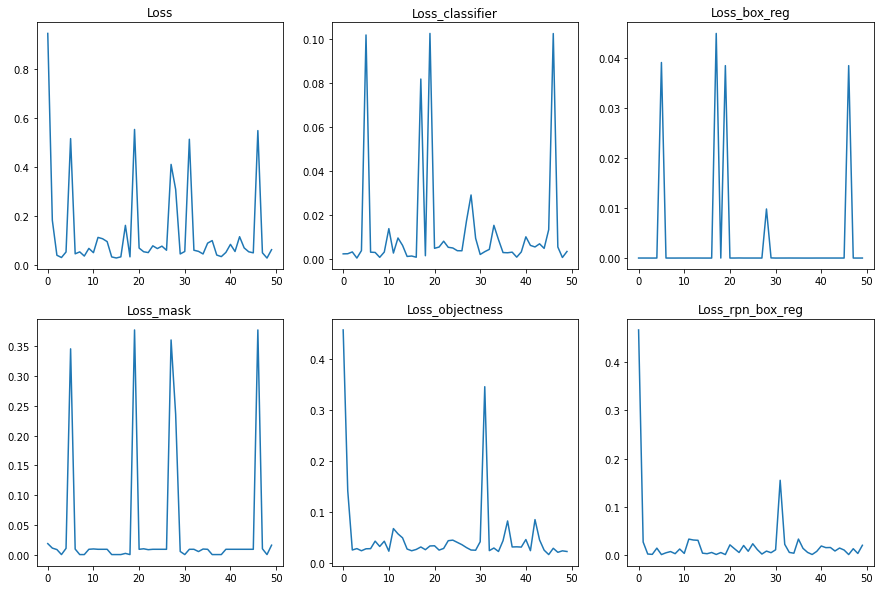

In [53]:
fig, ax = plt.subplots(2,3, figsize=(15,10))

ax[0,0].plot(range(len(logs)),losses)
ax[0,0].set_title('Loss')
ax[0,1].plot(range(len(logs)),losses_class)
ax[0,1].set_title('Loss_classifier')
ax[0,2].plot(range(len(logs)),losses_box_reg)
ax[0,2].set_title('Loss_box_reg')
ax[1,0].plot(range(len(logs)),losses_mask)
ax[1,0].set_title('Loss_mask')
ax[1,1].plot(range(len(logs)),losses_objectness)
ax[1,1].set_title('Loss_objectness')
ax[1,2].plot(range(len(logs)),losses_rpn_box_reg)
ax[1,2].set_title('Loss_rpn_box_reg')

In [52]:
torch.max(predictions[2]['masks'])

tensor(0.0048, device='cuda:0', grad_fn=<MaxBackward1>)

In [ ]:
# torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': loss,
#             ...
#             }, PATH)

In [33]:
model = model.cpu()

In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (lesion) + background
num_classes = 3  # 2 classes (lesion benign + lesion malignant) + background


# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [13]:
predictions

[{'boxes': tensor([[2.5803e+02, 2.3219e+02, 3.9800e+02, 2.9883e+02],
          [1.1064e+02, 1.4831e+02, 1.4184e+02, 1.6377e+02],
          [1.0749e+02, 1.3834e+02, 1.3233e+02, 1.7288e+02],
          [1.5622e+02, 1.9665e+02, 1.8711e+02, 2.1219e+02],
          [1.6788e+02, 1.8433e+02, 1.9201e+02, 2.2053e+02],
          [1.1911e+02, 1.3744e+02, 1.4418e+02, 1.7179e+02],
          [1.7898e+02, 1.8363e+02, 2.0447e+02, 2.1935e+02],
          [1.6970e+02, 1.9679e+02, 2.0021e+02, 2.1216e+02],
          [1.6757e+02, 1.7333e+02, 1.9111e+02, 2.0816e+02],
          [1.5799e+02, 1.8500e+02, 1.8792e+02, 2.0049e+02],
          [1.3170e+02, 1.3631e+02, 1.5699e+02, 1.7156e+02],
          [1.7809e+02, 2.9156e+02, 2.2092e+02, 3.0000e+02],
          [1.3280e+02, 1.4856e+02, 1.6463e+02, 1.6433e+02],
          [1.5361e+02, 2.9105e+02, 1.9505e+02, 3.0000e+02],
          [1.9327e+02, 1.7342e+02, 2.2308e+02, 1.8913e+02],
          [1.8191e+02, 1.9727e+02, 2.1213e+02, 2.1275e+02],
          [1.9056e+02, 1.0140e+

In [9]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [10]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [11]:
import utils as vision_utils

In [26]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.to(device)
output = model(image_list, target_list)   # Returns losses and detections

# For inference
model.eval()
x = [torch.rand(3,300,400), torch.rand(3,500,400)]
predictions = model(x)           # Returns predictions

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [13]:
predictions

[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)},
 {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)}]

In [14]:
output

{'loss_classifier': tensor(0.0169, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.0004, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(11.8512, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(35.1903, grad_fn=<DivBackward0>)}